# Projet: Gold Enrichment

## 1. Data preparation


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

!pip install optuna
import optuna

from sklearn import (linear_model,
                     preprocessing,
                     metrics,
                     model_selection,
                     ensemble,
                     dummy,
                     feature_selection)

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

import time
import math

!pip install sweetviz
import sweetviz as sv

#!pip install umap-learn
from umap import UMAP

!pip install lightgbm
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

### 1.1 Opening and examining the files

In [2]:
pth1 = r'C:\Users\exeve\Downloads\gold_industry_train.csv'
pth2 = r'C:\Users\exeve\Downloads\gold_industry_test.csv'
pth3 = r'C:\Users\exeve\Downloads\gold_industry_full.csv'
pth4 = '/datasets/gold_industry_train.csv'
pth5 = '/datasets/gold_industry_test.csv'
pth6 = '/datasets/gold_industry_full.csv'

try:
    if os.path.exists(pth1):
        data_train = pd.read_csv(pth1)
    elif os.path.exists(pth4):
        data_train = pd.read_csv(pth4)
except:
    print('Something went wrong with the train data')
    
try:
    if os.path.exists(pth2):
        data_test = pd.read_csv(pth2)
    elif os.path.exists(pth5):
        data_test = pd.read_csv(pth5)
except:
    print('Something went wrong with the test data')
    
try:
    if os.path.exists(pth3):
        data_full = pd.read_csv(pth3)
    elif os.path.exists(pth6):
        data_full = pd.read_csv(pth6)
except:
    print('Something went wrong with the full data')

In [3]:
print(data_train.shape)
print(data_test.shape)
print(data_full.shape)

(14579, 87)
(4860, 53)
(19439, 87)


In [116]:
report_full = sv.analyze(data_full)
report_full.show_html('gold_enrichment_sweetviz_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report gold_enrichment_sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### 1.2. Checking that the enrichment efficiency is calculated correctly. We will calculate it on the training set for the rougher.output.recovery feature and we will find the MAE between the calculations and the value of the feauture.

Enrichment efficiency is calculated using the formula:

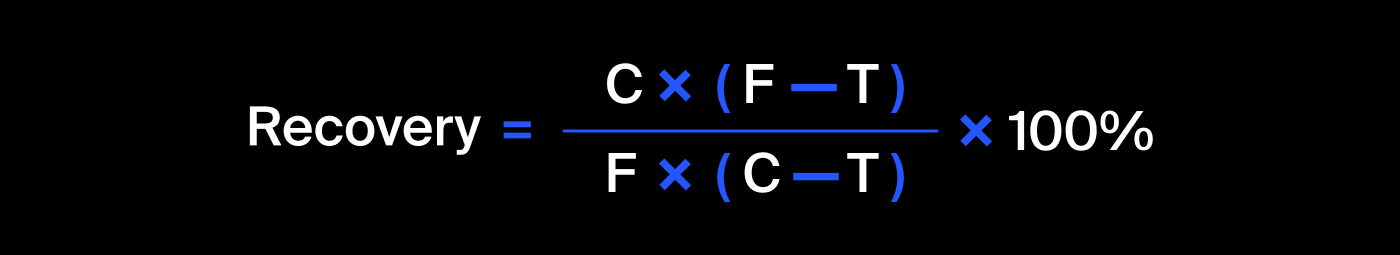

- C — the proportion of gold in the concentrate after flotation/refining;
- F — the share of gold in the raw material/concentrate before flotation/refining;
- T — share of gold in waste tailings after flotation/refining.

,real_recovery,estimated_recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,88.280699,88.280699



MAE: 9.83758577644259e-15; Calculated in 0.0009069442749023438 seconds





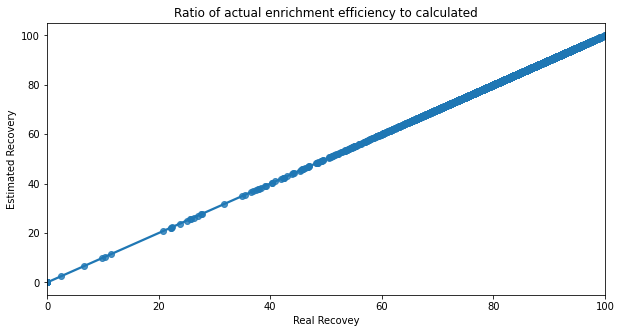

In [4]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

rougher_recovery_data = pd.DataFrame()
rougher_recovery_data['real_recovery'] = data_train['rougher.output.recovery']
rougher_recovery_data['estimated_recovery'] = (C*(F-T))/(F*(C-T))*100

start_time = time.time()
MAE = abs(rougher_recovery_data['real_recovery'] - rougher_recovery_data['estimated_recovery']).sum() / \
len(rougher_recovery_data)
end_time = time.time()

display(rougher_recovery_data.head(10))
print('')
print(f'MAE: {MAE}; Calculated in {end_time - start_time} seconds')
print('\n\n')
#график
plt.figure(figsize=(10,5))
plt.title('Ratio of actual enrichment efficiency to calculated', size = 12)
ax = sns.regplot(x = rougher_recovery_data['real_recovery'], y = rougher_recovery_data['estimated_recovery'] )
ax.set(xlabel = 'Real Recovey', ylabel = 'Estimated Recovery')
plt.show()



The error in the calculation is smaller than the scale of an atom. So the enrichment efficiency is calculated correctly.

### 1.3. Let's analyze the features not available in the testing sample

In [5]:
columns_train = data_train.columns
columns_test = data_test.columns

missing_columns = []

for column in columns_train:
    if column not in columns_test:
        missing_columns.append(column)
        
display(missing_columns)

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

Missing parameters in data_test correspond to the output data. They are the results of a previous process. Therefore, they cannot be used as features for model training, but can be used as targets.

### 1.4. Data preprocessing.

#### Gaps

In [6]:
# a function to calculate the gaps %

def gaps(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,14), rot = 0, legend = False, fontsize = 16, color = 'skyblue')
            .set_title('Missing values %' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('no gaps left  :)  ')

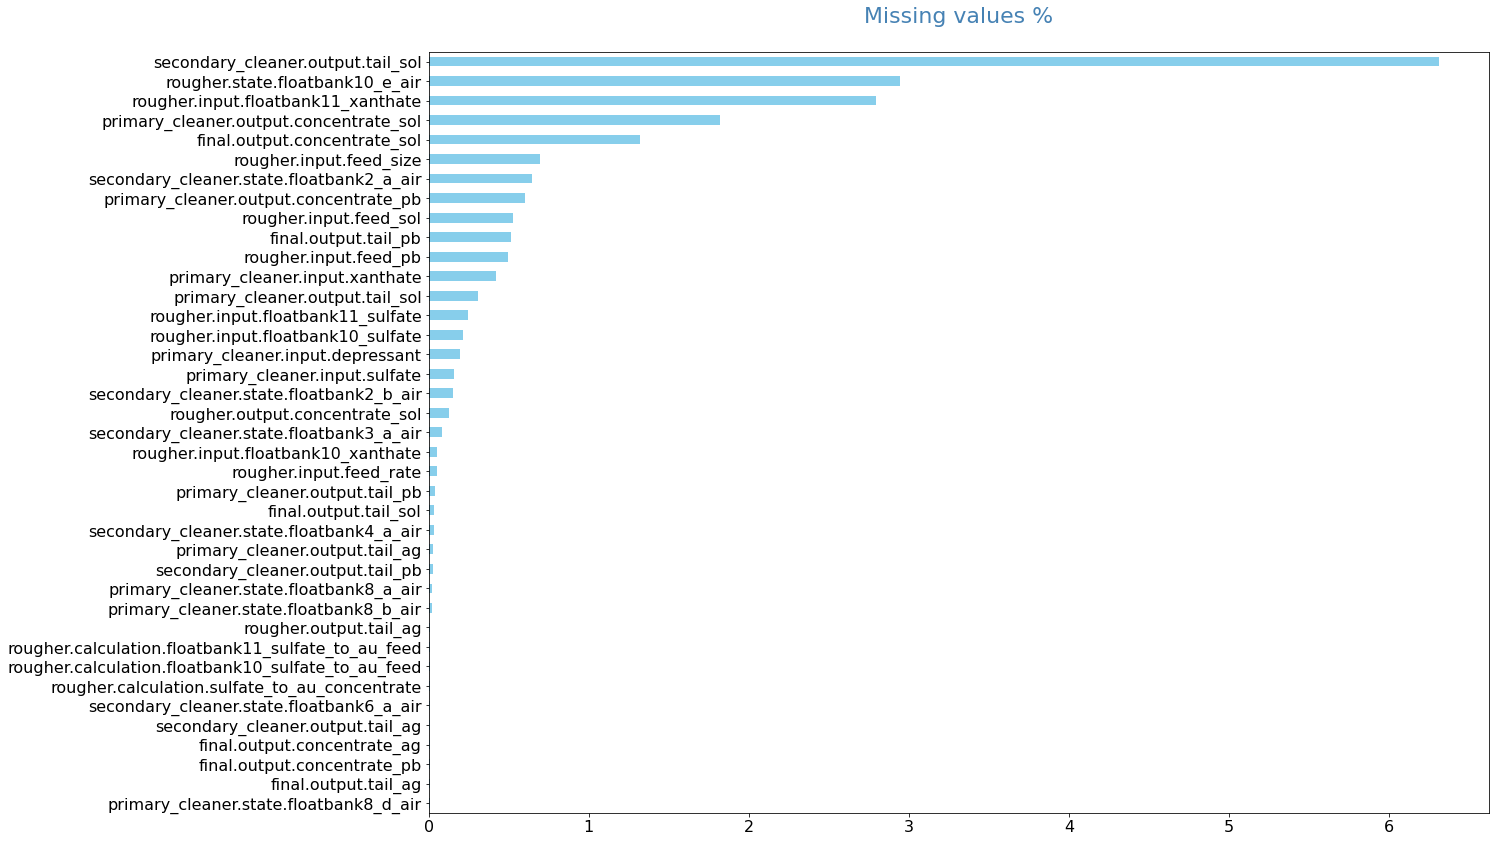

In [7]:
gaps(data_train)

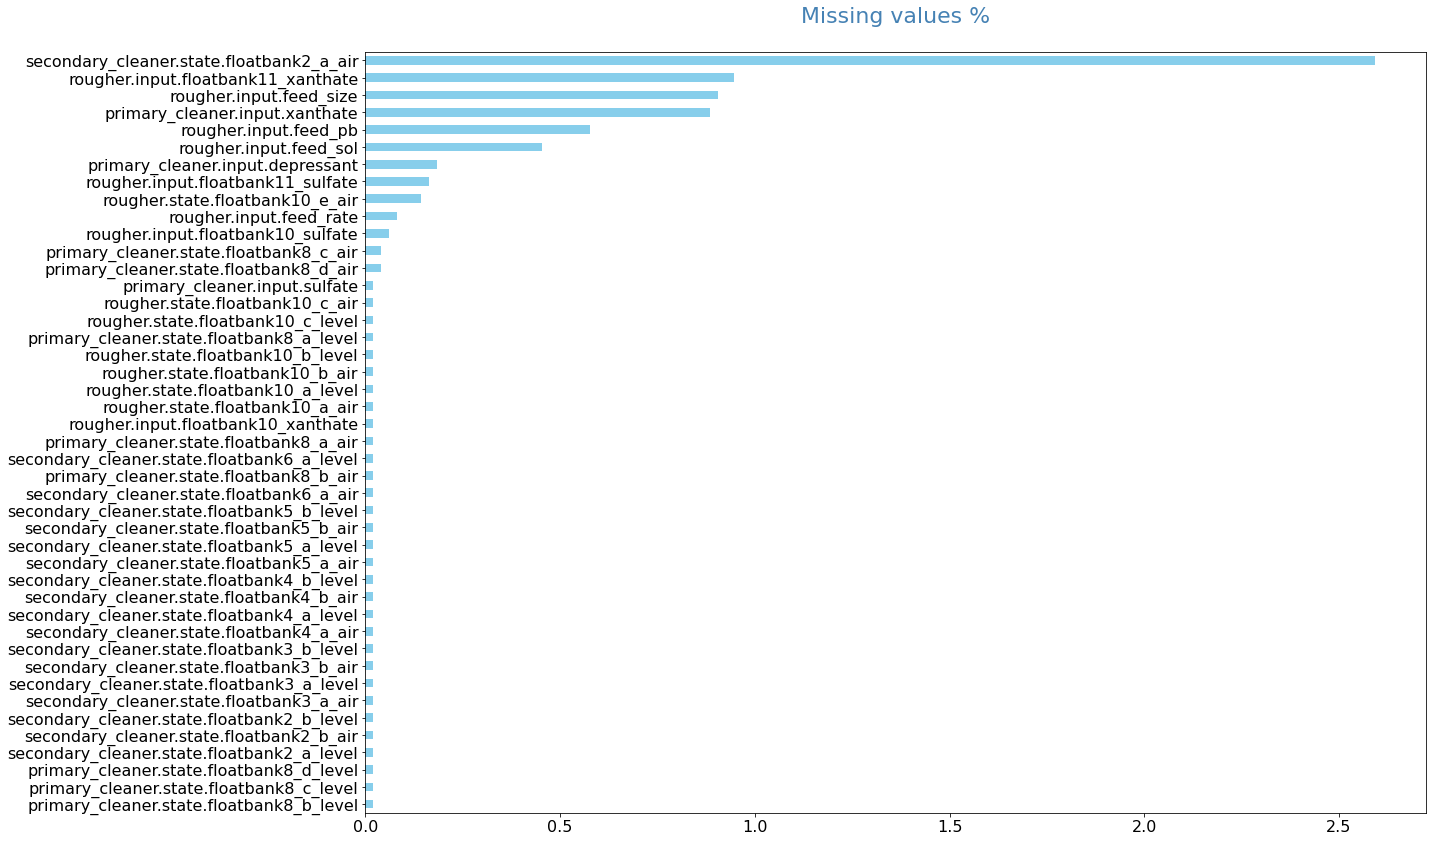

In [8]:
gaps(data_test)

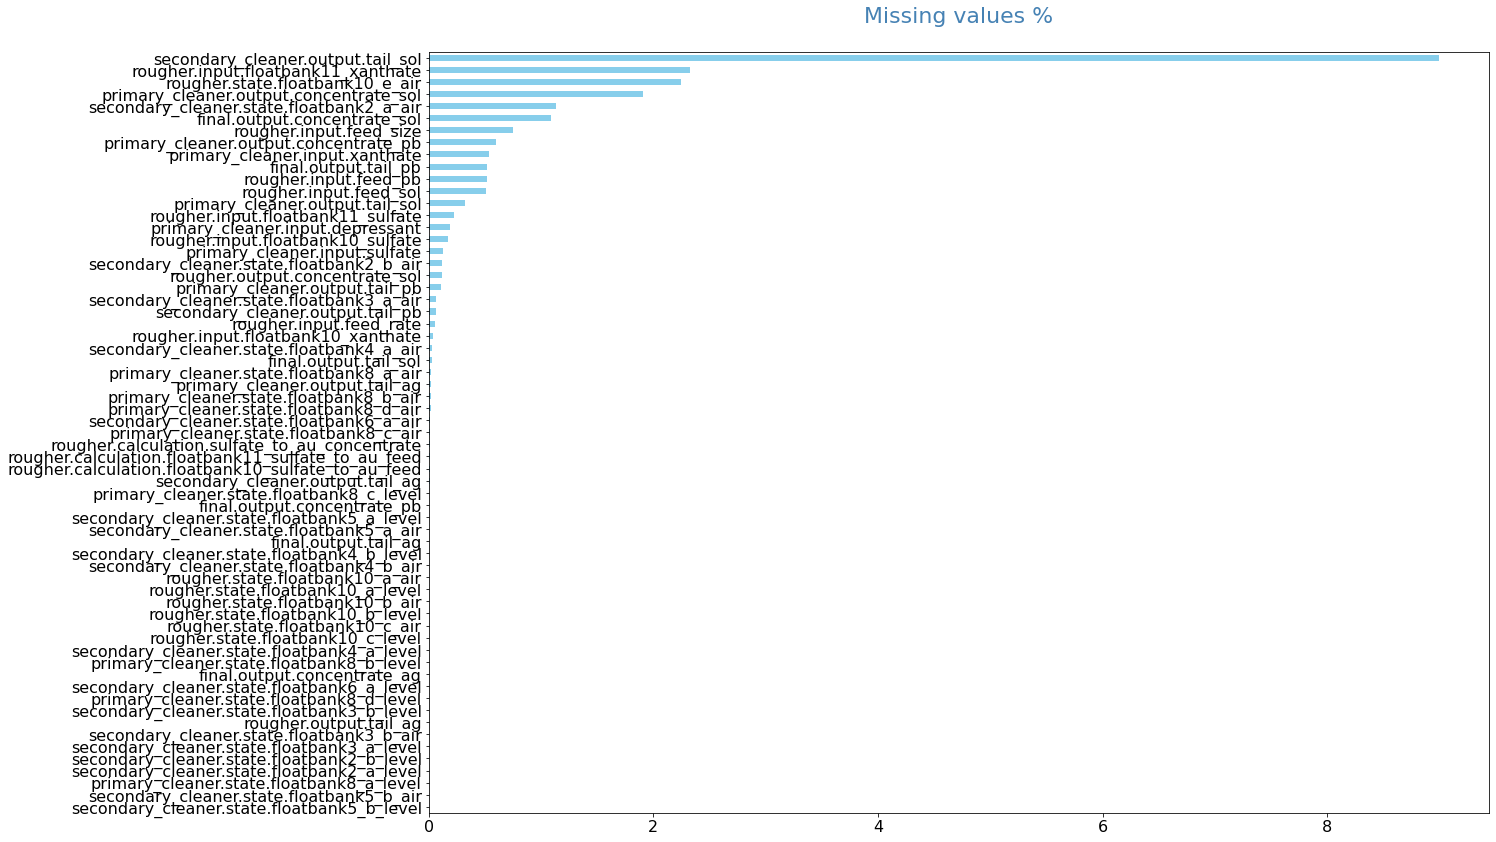

In [9]:
gaps(data_full)

In [10]:
data_train = data_train.fillna(data_train.median())
data_test = data_test.fillna(data_test.median())
data_full = data_full.fillna(data_full.median())

#### Dupliates

In [11]:
print(data_train.duplicated().sum())
print(data_test.duplicated().sum())
print(data_full.duplicated().sum())

0
0
0


#### Data types

In [12]:
print(data_train['date'].dtype)
print(data_test['date'].dtype)
print(data_full['date'].dtype)

object
object
object


In [13]:
data_train['date'] = pd.to_datetime(data_train['date'])
data_test['date'] = pd.to_datetime(data_test['date'])
data_full['date'] = pd.to_datetime(data_test['date'])


## 2. Analysis


### 2.1. Let's see how the concentration of metals (Au, Ag, Pb) changes at different stages: in the raw material, in the rough concentrate, in the concentrate after the first cleaning and in the final concentrate.



In [14]:
def SeeStageProgress (data, data2, title):
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    
    sns.distplot(data, color = 'lightgreen', label = 'Before')
    sns.distplot(data2, color = 'green', label = 'After')
    
    plt.axvline(data.median(), color = 'black')
    plt.axvline(data2.median(), color = 'black')
    
    plt.xlabel(xlabel = 'Concentration in %', fontsize=18)
    plt.ylabel(ylabel = 'Density', fontsize=18)
    ax.xaxis.set_label_coords(0.45, -0.08)
    ax.yaxis.set_label_coords(-0.08, 0.5)
    
    plt.legend(fontsize=18, loc='best')
    plt.title(title, fontsize=20, y = 1.05)
    

### Before and after flotation

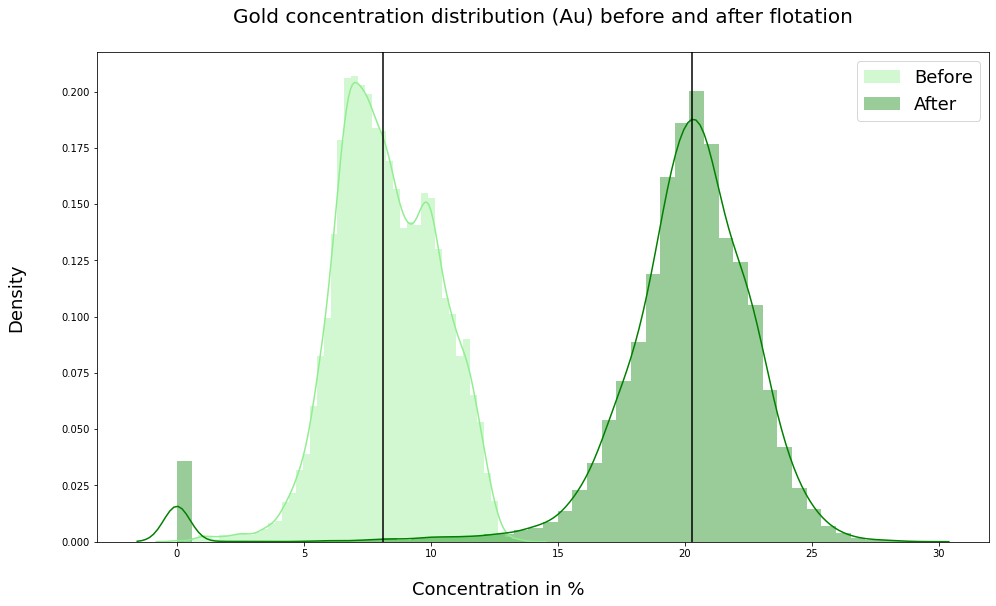

In [15]:
SeeStageProgress(data_full['rougher.input.feed_au'], data_full['rougher.output.concentrate_au'], 
                 'Gold concentration distribution (Au) before and after flotation')

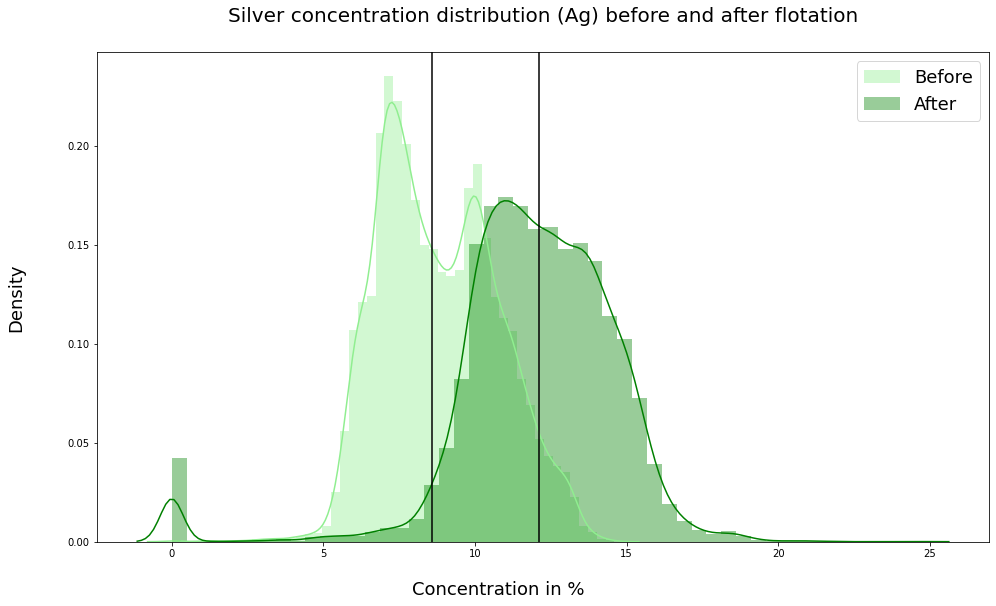

In [16]:
SeeStageProgress(data_full['rougher.input.feed_ag'], data_full['rougher.output.concentrate_ag'], 
                 'Silver concentration distribution (Ag) before and after flotation')

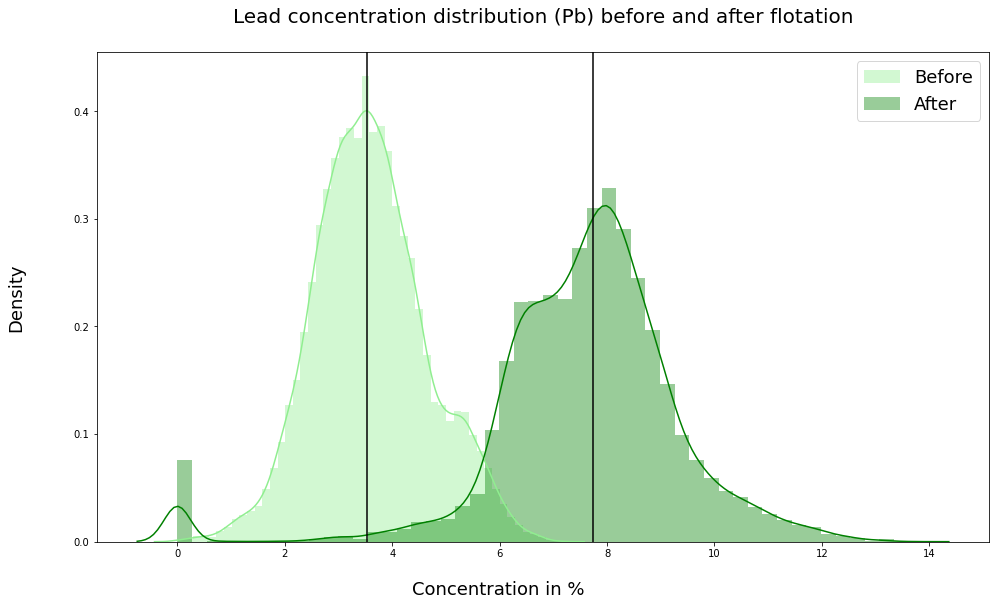

In [17]:
SeeStageProgress(data_full['rougher.input.feed_pb'], data_full['rougher.output.concentrate_pb'], 
                 'Lead concentration distribution (Pb) before and after flotation')

### Before and after the first stage of cleaning

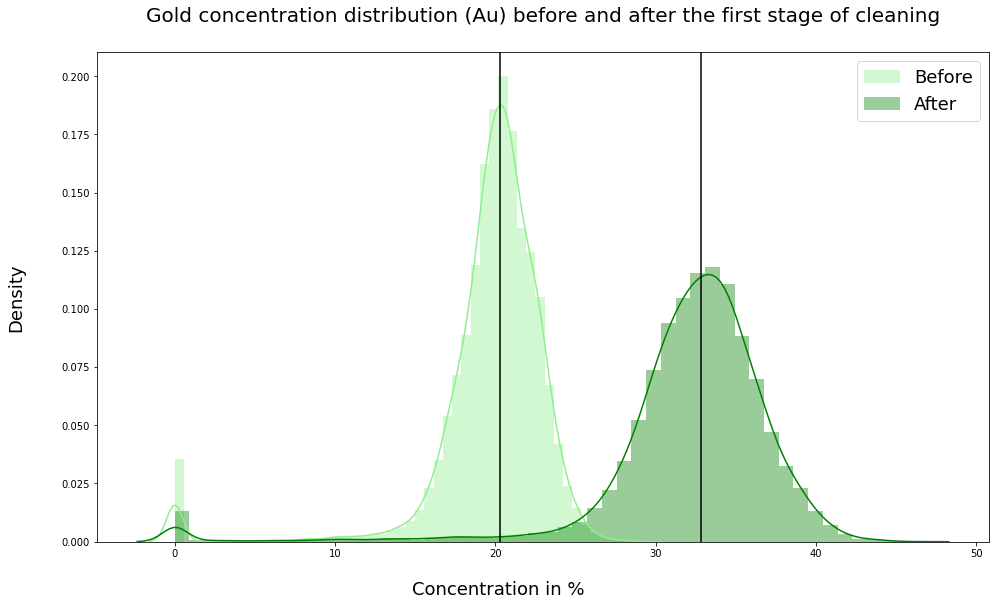

In [18]:
SeeStageProgress(data_full['rougher.output.concentrate_au'], data_full['primary_cleaner.output.concentrate_au'],\
              'Gold concentration distribution (Au) before and after the first stage of cleaning')

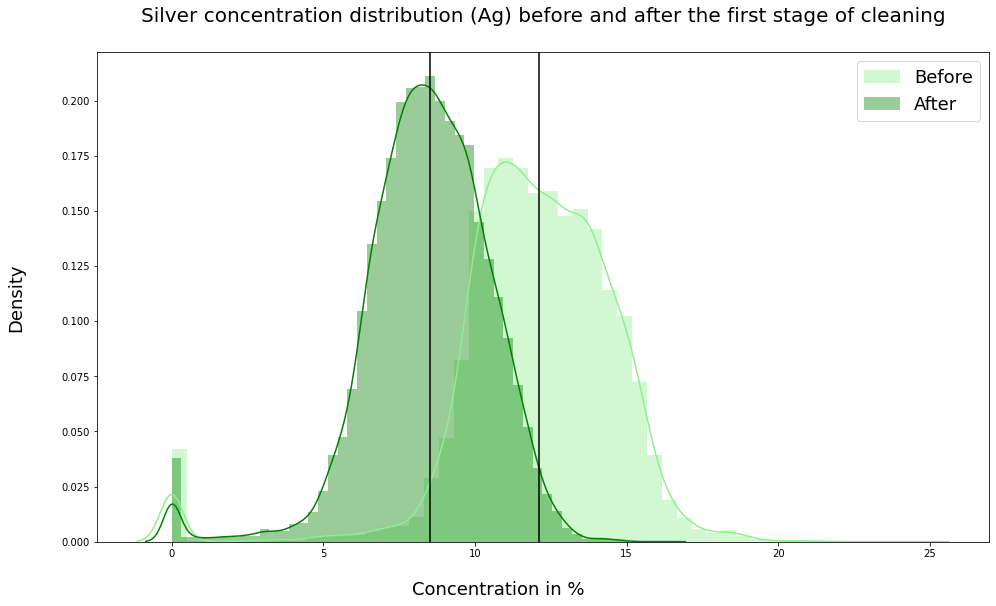

In [19]:
SeeStageProgress(data_full['rougher.output.concentrate_ag'], data_full['primary_cleaner.output.concentrate_ag'],\
              'Silver concentration distribution (Ag) before and after the first stage of cleaning')

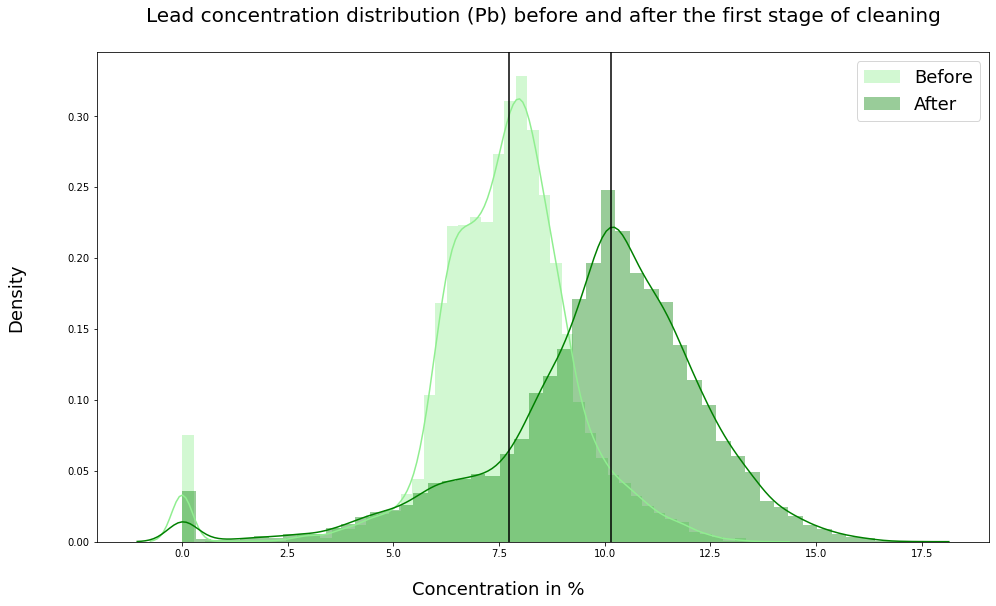

In [20]:
SeeStageProgress(data_full['rougher.output.concentrate_pb'], data_full['primary_cleaner.output.concentrate_pb'],\
              'Lead concentration distribution (Pb) before and after the first stage of cleaning')

### Before and after the second stage of cleaning

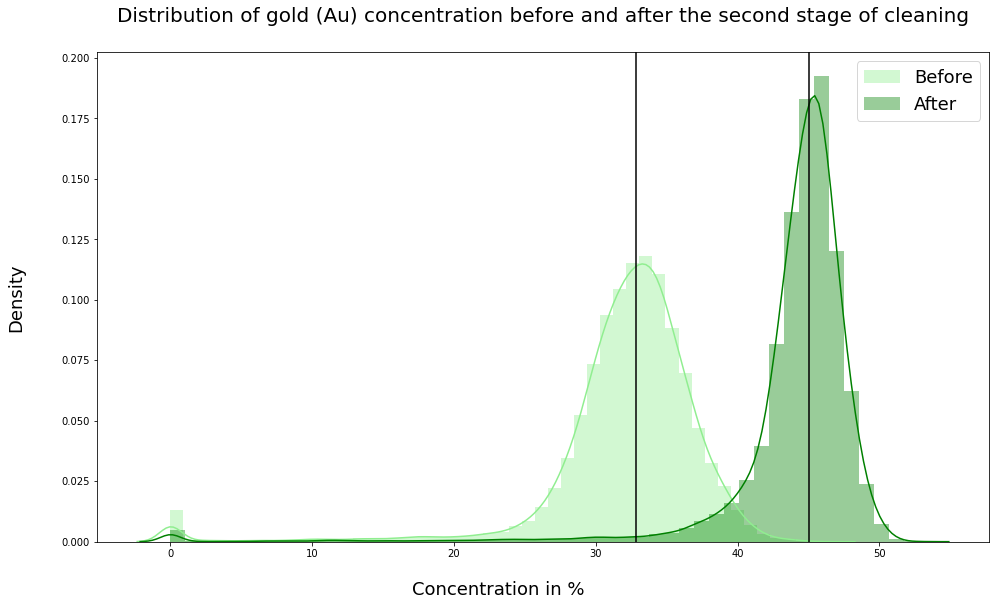

In [21]:
SeeStageProgress(data_full['primary_cleaner.output.concentrate_au'], data_full['final.output.concentrate_au'],\
              'Distribution of gold (Au) concentration before and after the second stage of cleaning')

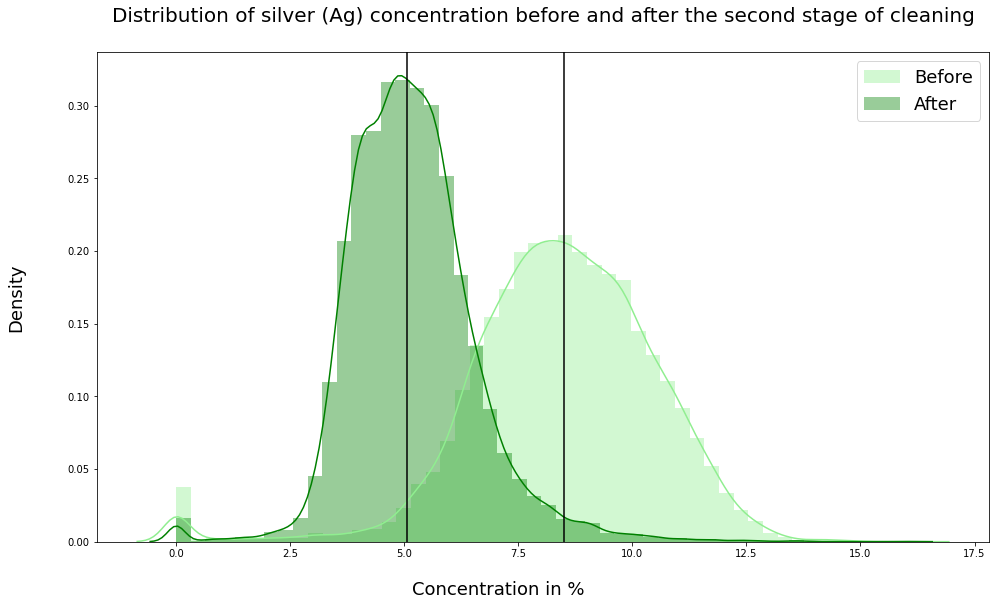

In [22]:
SeeStageProgress(data_full['primary_cleaner.output.concentrate_ag'], data_full['final.output.concentrate_ag'],\
              'Distribution of silver (Ag) concentration before and after the second stage of cleaning')

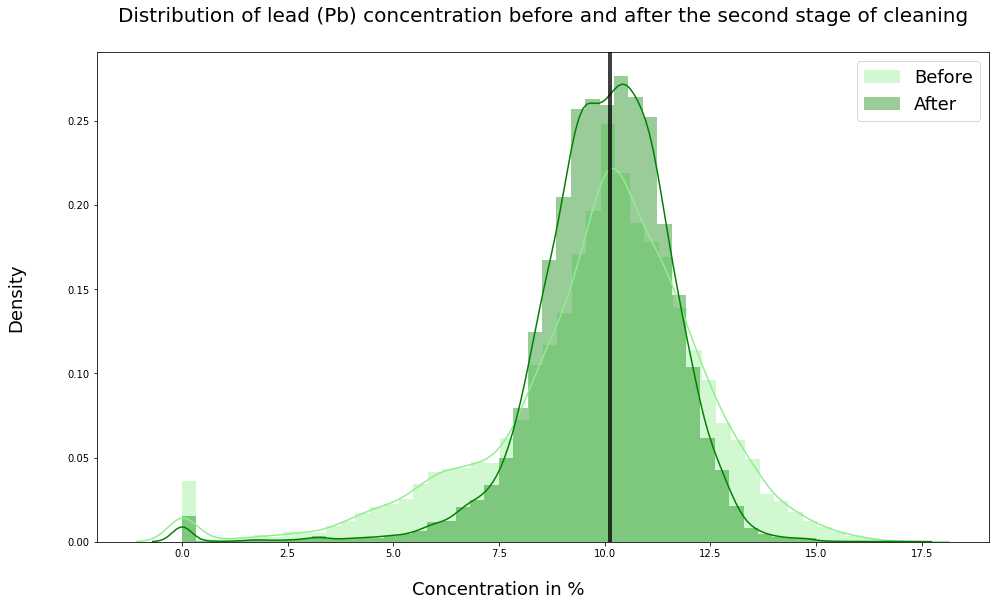

In [23]:
SeeStageProgress(data_full['primary_cleaner.output.concentrate_pb'], data_full['final.output.concentrate_pb'],\
              'Distribution of lead (Pb) concentration before and after the second stage of cleaning')

#### Table of rises and falls in metal concentrations between stages

In [24]:
stages = ['Before and after flotation', ' Before and after the first stage of cleaning', ' Before and after the second stage of cleaning']
indexes = ['Au', 'Ag', 'Pb']
results_metals = pd.DataFrame(columns = stages, index = indexes)

au_rate = ['up', 'up', 'up']
ag_rate = ['up','down','down']
pb_rate = ['up','up','same']

results_metals.loc['Au', :] = au_rate
results_metals.loc['Ag', :] = ag_rate
results_metals.loc['Pb', :] = pb_rate

results_metals

,Before and after flotation,Before and after the first stage of cleaning,Before and after the second stage of cleaning
Au,up,up,up
Ag,up,down,down
Pb,up,up,same


- The concentration of gold increases at each stage.
- After flotation, the concentration of all metals increases.
- After the first stage of purification, the concentration of silver decreases, and the concentration of lead continues to increase.
- After the second stage of purification, we can see that the concentration of silver continued to decrease, but the concentration of lead remained the same.

#### We will remove the outliers where the metal concentration is zero

In [25]:
data_full = data_full.loc[(data_full['rougher.input.feed_au'] > 1) & (data_full['rougher.input.feed_ag'] > 1) &
                         (data_full['rougher.input.feed_pb'] > 1) & (data_full['rougher.output.concentrate_au'] > 1) & 
                    (data_full['rougher.output.concentrate_ag'] > 1) & (data_full['rougher.output.concentrate_pb'] > 1) &
                 (data_full['rougher.output.concentrate_pb'] > 1) & (data_full['primary_cleaner.output.concentrate_au'] > 1) &
        (data_full['primary_cleaner.output.concentrate_ag'] > 1) & (data_full['primary_cleaner.output.concentrate_pb'] > 1) &
                          (data_full['final.output.concentrate_au'] > 1) & (data_full['final.output.concentrate_pb'] > 1) &
                          (data_full['final.output.concentrate_ag'] > 1)]
                          



data_train = data_train.loc[(data_train['rougher.input.feed_au'] > 1) & (data_train['rougher.input.feed_ag'] > 1) &
                         (data_train['rougher.input.feed_pb'] > 1) & (data_train['rougher.output.concentrate_au'] > 1) & 
                    (data_train['rougher.output.concentrate_ag'] > 1) & (data_train['rougher.output.concentrate_pb'] > 1) &
                 (data_train['rougher.output.concentrate_pb'] > 1) & (data_train['primary_cleaner.output.concentrate_au'] > 1) &
        (data_train['primary_cleaner.output.concentrate_ag'] > 1) & (data_train['primary_cleaner.output.concentrate_pb'] > 1) &
                          (data_train['final.output.concentrate_au'] > 1) & (data_train['final.output.concentrate_pb'] > 1) &
                          (data_train['final.output.concentrate_ag'] > 1)]     
    
        
    


### 2.2.  Comparing the size distributions of raw material granules on the training and test samples.

In [26]:
def SeeFeedSize (data, data2, title):
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    
    sns.distplot(data, color = 'blue', label = 'Training Sample')
    sns.distplot(data2, color = 'red', label = 'Testing Sample')
    
    plt.axvline(data.median(), color = 'black')
    plt.axvline(data2.median(), color = 'black')
    
    plt.xlabel(xlabel = 'Granule Size', fontsize=18)
    plt.ylabel(ylabel= 'Density', fontsize = 18)
    ax.xaxis.set_label_coords(0.45, -0.08)
    ax.yaxis.set_label_coords(-0.08, 0.45)
    
    plt.legend(fontsize=18, loc='best')
    plt.title(title, fontsize=20, y = 1.05)



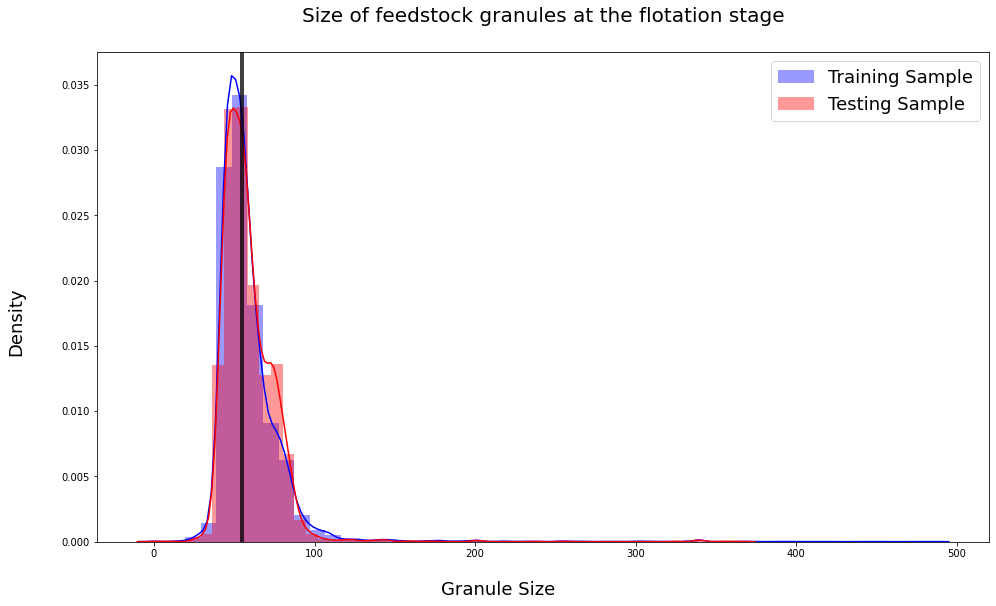

In [27]:
SeeFeedSize(data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size'], \
            'Size of feedstock granules at the flotation stage' )

In [28]:
from scipy import stats

a = data_train['rougher.input.feed_size']
b = data_test['rougher.input.feed_size']

print(a.var())
print(b.var())



509.9830341644585
362.5746559969015


In [29]:
test = stats.ttest_ind(a,b, equal_var = False)
alpha = 0.5


if test.pvalue > alpha:
    print('Not particularly different')
else:
    print('Different!!')

Not particularly different


- The graphs show that the distributions do not differ much from each other. So, the model assessment should be normal.

### 2.3. Examining the total concentration of metals at different stages: in raw materials, in rough concentrate, in concentrate after the first cleaning and in the final concentrate.

In [30]:
data_full['rougher.input.feed_sum'] = data_full['rougher.input.feed_ag']\
+ data_full['rougher.input.feed_pb'] \
+ data_full['rougher.input.feed_sol']\
+ data_full['rougher.input.feed_au']

data_full['rougher.output.concentrate_sum'] = data_full['rougher.output.concentrate_ag']\
+ data_full['rougher.output.concentrate_pb']\
+ data_full['rougher.output.concentrate_sol']\
+ data_full['rougher.output.concentrate_au']

data_full['primary_cleaner.output.concentrate_sum'] = data_full['primary_cleaner.output.concentrate_ag']\
+ data_full['primary_cleaner.output.concentrate_pb']\
+ data_full['primary_cleaner.output.concentrate_sol']\
+ data_full['primary_cleaner.output.concentrate_au'] 

data_full['final.output.concentrate_sum'] = data_full['final.output.concentrate_ag']\
+ data_full['final.output.concentrate_pb'] \
+ data_full['final.output.concentrate_sol']\
+ data_full['final.output.concentrate_au']


In [31]:
def SeeFeedSums (data, data2, data3, data4):
    
    fig, ax = plt.subplots(figsize=(16,14))
    
    
    sns.distplot(data, color = 'red', label = 'in raw materials', )
    sns.distplot(data2, color = 'green', label = 'in rough concentrate')
    sns.distplot(data3, color = 'blue', label = 'in concentrate after first cleaning')
    sns.distplot(data4, color = 'yellow', label = 'in the final concentrate')
    
    plt.axvline(data.median(), color = 'black')
    plt.axvline(data2.median(), color = 'brown')
    plt.axvline(data3.median(), color = 'black')
    plt.axvline(data4.median(), color = 'black')
    
    plt.xlabel(xlabel = 'Total Metal Concentration in %', fontsize=18)
    plt.ylabel(ylabel = 'Density', fontsize=18)
    ax.xaxis.set_label_coords(0.5, -0.05)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    
    plt.legend(fontsize=15, loc='best')
    plt.title('Total concentration of metals at different stages', fontsize=20, y = 1.05)
    plt.xlim(35,90)

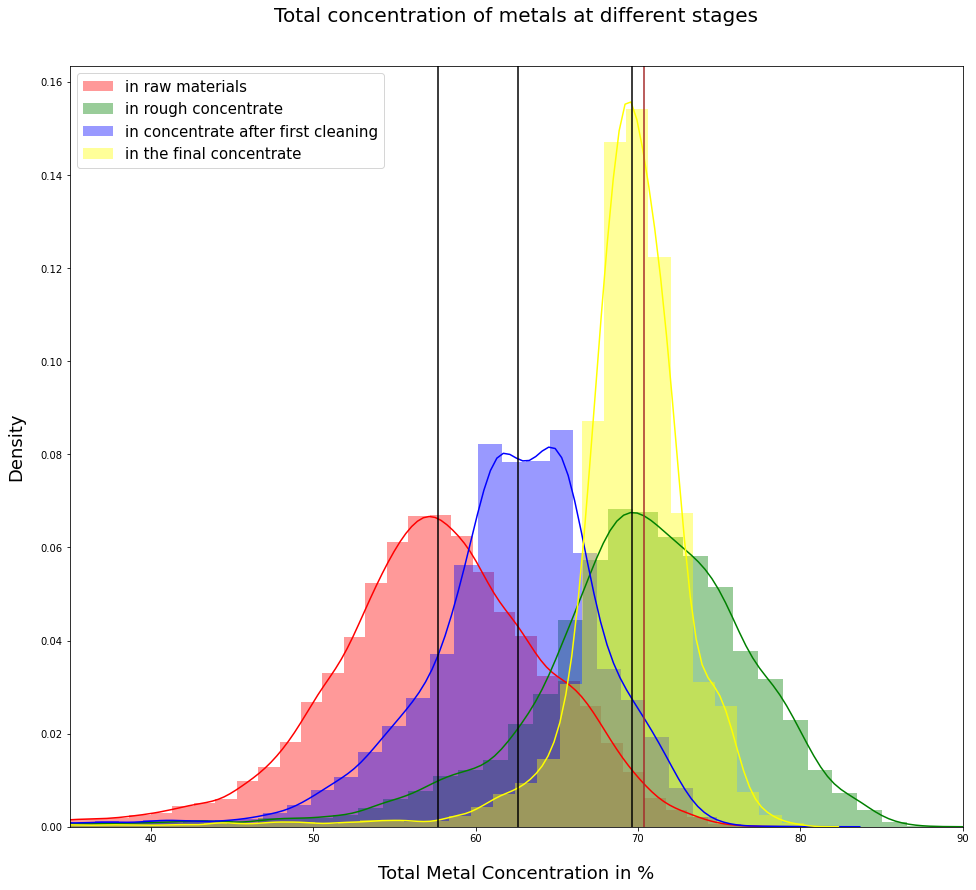

In [32]:
SeeFeedSums(data_full['rougher.input.feed_sum'],data_full['rougher.output.concentrate_sum'], \
           data_full['primary_cleaner.output.concentrate_sum'], \
           data_full['final.output.concentrate_sum'])

It can be seen that the total concentration increases significantly after flotation.
Surprisingly, after the first cleaning it decreases sharply, and after the second cleaning it increases again.

In the end, the combined concentration of metals remains slightly higher than that which was after the second cleaning but less than that which was after flotation, and the distribution shifts towards the average.

- After analyzing the data, we found that:


     - The concentration of gold increases at each stage.
     - After flotation, the concentration of all metals increases.
     - After the first stage of cleaning, the concentration of silver decreases, and the concentration of lead continues to increase.
     - After the second stage of purification, we can see that the concentration of silver continued to decrease, but the concentration of lead remained the same.

     - The size distributions of raw material granules on the training and test samples do not differ much from each other. So, the model assessment should be normal.

     - The total concentration increases significantly after flotation.
     - After the first cleaning it decreases sharply, and after the second cleaning it increases again.
     - In the end, the combined concentration of metals remains slightly higher than that which was after the second cleaning but less than that which was after flotation, and the distribution shifts towards the average.
    
     We also removed outliers that could interfere with model training.

## 3. Building a model


### 3.1. Let's write a function to calculate the final sMAPE.


- sMAPE (Symmetric Mean Absolute Percentage Error, “symmetric mean absolute percentage deviation”).
- It is similar to MAE, but expressed not in absolute values, but in relative ones. Why symmetrical? It equally takes into account the scale of both the target feature and the prediction.

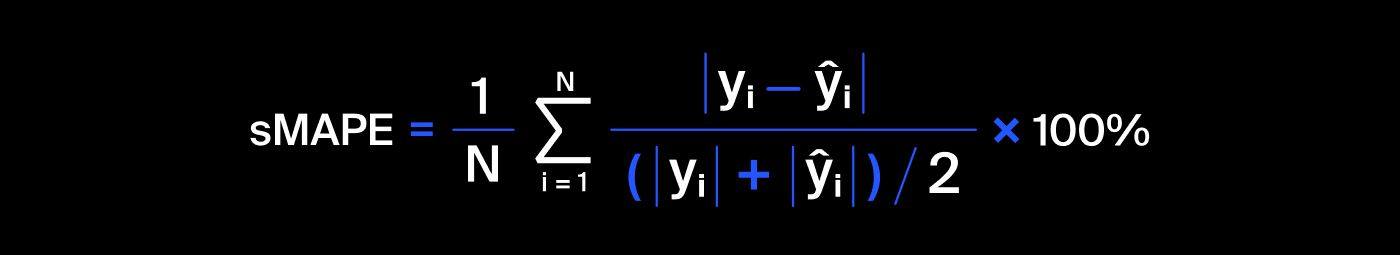

The final metric consists of two values:

**Final sMAPE = 25% x sMAPE(rougher) + 75% x sMAPE(final)**

In [33]:
def sMAPE(target, prediction):
    
    target_ = target.reset_index(drop = True)
    prediction_ = pd.Series(prediction).reset_index(drop = True)

    data_ = pd.DataFrame({'y':target_, 'ÿ':prediction_})

    data_['smape'] = abs(data_['y'] - data_['ÿ']) / ((abs(data_['y']) + abs(data_['ÿ'])) / 2)

    return data_['smape'].sum() / len(target_) * 100

In [34]:
def sMAPE_final (sMAPE_rougher, sMAPE_final):
    return 0.25 * sMAPE_rougher + 0.75 * sMAPE_final

### 3.2. We will train different models and evaluate their quality using cross-validation. We select the best model and test it on a test sample.

It is necessary to predict two quantities at once:
- efficiency of the rough concentrate enrichment **rougher.output.recovery**;
- efficiency of the final concentrate enrichment **final.output.recovery**.

### Function for correlation checking

In [35]:
def correlation (data):
    plt.figure(figsize=(20,9))
    corr = data.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot = True)

### Function for selecting the best hyperparameters

This is a function that performs cross validation with all possible parameters among those we specify, and indicates with which parameters the cross validation results were the best. The caveat is that it requires a lot of calculations and a lot of time.

In [36]:
def cross_grid(model, params, features, target, cv):

    
    grid_search = model_selection.GridSearchCV(model,
                      param_grid=params,
                      cv = cv,
                      scoring = metrics.make_scorer(sMAPE, greater_is_better = False),
                      n_jobs = -1,
                      verbose = 300
                    )
    
    grid_search.fit(features, target)
    
    return grid_search.best_params_, grid_search.best_score_, grid_search.refit_time_

## Predicting the rougher.output.recovery target 

### Features for the rougher.output.recovery target
 
Let's take every feature that is not output or calculation at the flotation stage.

In [37]:
rougher_cols = [
'rougher.input.feed_ag',
'rougher.input.feed_pb',
'rougher.input.feed_rate',
'rougher.input.feed_size',
'rougher.input.feed_sol',
'rougher.input.feed_au',
'rougher.input.floatbank10_sulfate',
'rougher.input.floatbank10_xanthate',
'rougher.input.floatbank11_sulfate',
'rougher.input.floatbank11_xanthate',
'rougher.state.floatbank10_a_air',
'rougher.state.floatbank10_a_level',
'rougher.state.floatbank10_b_air',
'rougher.state.floatbank10_b_level',
'rougher.state.floatbank10_c_air',
'rougher.state.floatbank10_c_level',
'rougher.state.floatbank10_d_air',
'rougher.state.floatbank10_d_level',
'rougher.state.floatbank10_e_air',
'rougher.state.floatbank10_e_level',
'rougher.state.floatbank10_f_air',
'rougher.state.floatbank10_f_level'
    
]

rougher_features = data_train[rougher_cols]
rougher_target = data_train['rougher.output.recovery']
rougher_all = rougher_features.join(rougher_target)

### Checking correlation

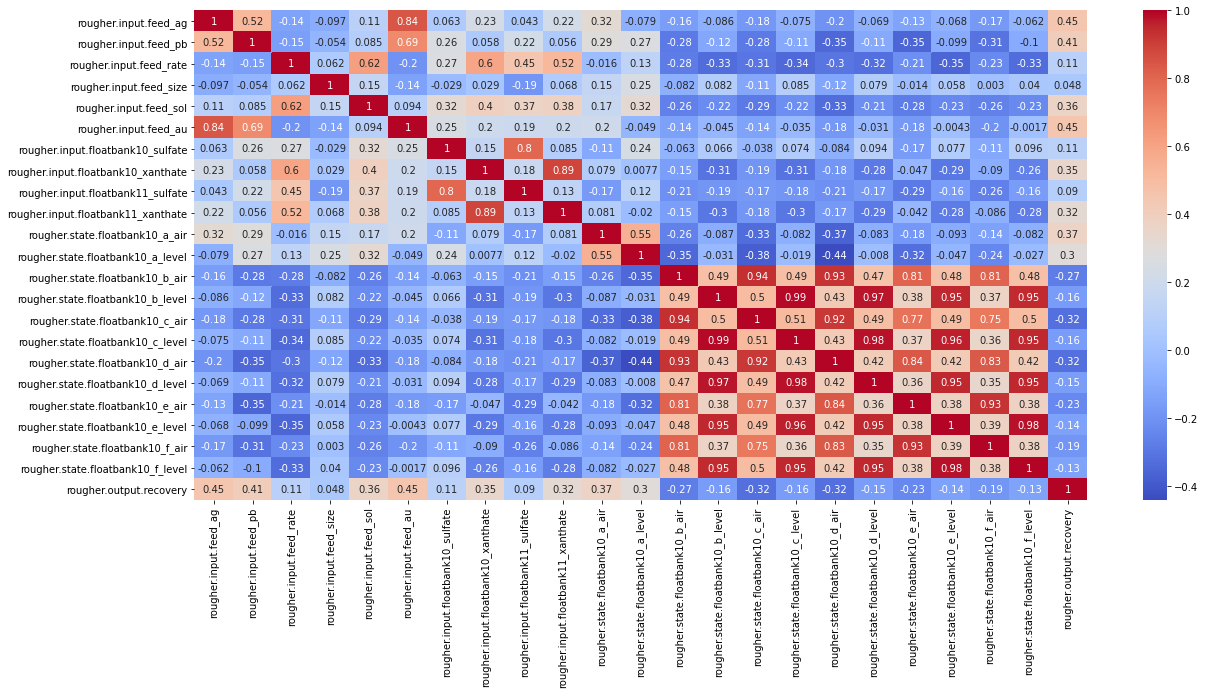

In [38]:
correlation(rougher_all)

We can see that there are a few features that correlate (correlation coefficient greater than 0.9).

### Let's make it easier to see which features are specifically correlated

In [39]:
class color:

   BOLD = '\033[1m'
   END = '\033[0m'
   RED = '\033[91m'


for i in rougher_all.columns:
    for k in rougher_all.columns:
        if abs(rougher_all[i].corr(rougher_all[k])) >= 0.85 and i != k :
            print(f'Features {color.BOLD + i + color.END} and {color.BOLD + k + color.END} {color.RED + "DO CORRELATE" + color.END}')
 

Features rougher.input.floatbank10_xanthate and rougher.input.floatbank11_xanthate DO CORRELATE
Features rougher.input.floatbank11_xanthate and rougher.input.floatbank10_xanthate DO CORRELATE
Features rougher.state.floatbank10_b_air and rougher.state.floatbank10_c_air DO CORRELATE
Features rougher.state.floatbank10_b_air and rougher.state.floatbank10_d_air DO CORRELATE
Features rougher.state.floatbank10_b_level and rougher.state.floatbank10_c_level DO CORRELATE
Features rougher.state.floatbank10_b_level and rougher.state.floatbank10_d_level DO CORRELATE
Features rougher.state.floatbank10_b_level and rougher.state.floatbank10_e_level DO CORRELATE
Features rougher.state.floatbank10_b_level and rougher.state.floatbank10_f_level DO CORRELATE
Features rougher.state.floatbank10_c_air and rougher.state.floatbank10_b_air DO CORRELATE
Features rougher.state.floatbank10_c_air and rougher.state.floatbank10_d_air DO CORRELATE
Features rougher.state.floatbank10_c_level and rougher.state.floatbank10

### Let's delete the correlating features so that they do not disturb our model's quality

In [40]:
drop_list = ['rougher.input.floatbank10_xanthate',
             'rougher.state.floatbank10_b_air',
             'rougher.state.floatbank10_b_level', 
             'rougher.state.floatbank10_c_air', 
             'rougher.state.floatbank10_c_level', 
             'rougher.state.floatbank10_d_level',
             'rougher.state.floatbank10_e_air',
             'rougher.state.floatbank10_e_level']

rougher_features = rougher_features.drop(drop_list, axis = 1)
 

There is no correlation with the target.

In [41]:
rougher_features

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,11.836743,6.005818,999.706909,-404.066986,1598.937256,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,11.996163,6.012594,1000.286398,-400.065196,1600.527589,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,11.920305,6.204633,999.719565,-400.074028,1599.849325,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,11.692450,6.196578,999.814770,-400.200179,1597.725177,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,10.960521,6.194897,999.678690,-399.752729,1599.759049,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14574,5.822083,4.255546,559.895089,85.247019,37.480479,4.599524,6.775864,6.775291,9.000862,1200.454685,-300.012582,947.090150,850.139876,-498.721100
14575,5.844800,4.241564,561.464855,83.860651,37.395565,4.658125,6.770561,6.771708,9.001694,1200.958146,-300.013649,960.563638,850.462226,-500.703846
14576,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,7.766744,9.156069,1199.245914,-300.845518,946.640977,849.758091,-497.448664
14577,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,7.095508,9.297924,1196.569267,-299.512227,949.773589,850.013123,-496.822119


### Let's reduce the rougher dataset dimension using UMAP for faster computational performance

In [42]:
reducer = UMAP(force_approximation_algorithm=True)

In [43]:
rougher_features_reduced = reducer.fit_transform(rougher_features)

In [44]:
rougher_features_reduced

array([[10.396475 , -5.825701 ],
       [10.398476 , -5.8276167],
       [10.397914 , -5.8271084],
       ...,
       [ 6.2874727,  6.0076823],
       [ 6.28655  ,  6.009455 ],
       [ 6.2877207,  6.0077133]], dtype=float32)

### Looking for the best hyperparameters and the best model

#### Random Forest

In [45]:
%%time

forest = ensemble.RandomForestRegressor(random_state = 42)

    
params = {'n_estimators' : list(range(10, 310, 100)),
                'max_depth' : list(range(2,7,2))}


results_forest = cross_grid(forest, params, rougher_features_reduced, rougher_target, 3)

forests_params = results_forest[0]
forest_smape = abs(results_forest[1])
forest_time = results_forest[2]

print('Best params: ', results_forest[0])
print('Best sMAPE: ', abs(results_forest[1]))
print('Fitting time:', results_forest[2])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START max_depth=2, n_estimators=10................................
[CV 1/3; 1/9] END ..............max_depth=2, n_estimators=10; total time=   0.1s
[CV 2/3; 1/9] START max_depth=2, n_estimators=10................................
[CV 2/3; 1/9] END ..............max_depth=2, n_estimators=10; total time=   0.0s
[CV 3/3; 1/9] START max_depth=2, n_estimators=10................................
[CV 3/3; 1/9] END ..............max_depth=2, n_estimators=10; total time=   0.0s
[CV 1/3; 2/9] START max_depth=2, n_estimators=110...............................
[CV 1/3; 2/9] END .............max_depth=2, n_estimators=110; total time=   0.4s
[CV 2/3; 2/9] START max_depth=2, n_estimators=110...............................
[CV 2/3; 2/9] END .............max_depth=2, n_estimators=110; total time=   0.4s
[CV 3/3; 2/9] START max_depth=2, n_estimators=110...............................
[CV 3/3; 2/9] END .............max_depth=2, n_est

#### Decision Tree

In [94]:
%%time

tree = DecisionTreeRegressor(random_state = 42)

params = {'max_depth': list(range(1,10))}

results_tree = cross_grid(tree, params, rougher_features_reduced, rougher_target, 3)

tree_params = results_tree[0]
tree_smape = abs(results_tree[1])
tree_time = results_tree[2]

print('Best params: ', results_tree[0])
print('Best sMAPE: ', abs(results_tree[1]))
print('Best fitting time:', results_tree[2])


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START max_depth=1.................................................
[CV 1/3; 1/9] END ...............................max_depth=1; total time=   0.0s
[CV 2/3; 1/9] START max_depth=1.................................................
[CV 2/3; 1/9] END ...............................max_depth=1; total time=   0.0s
[CV 3/3; 1/9] START max_depth=1.................................................
[CV 3/3; 1/9] END ...............................max_depth=1; total time=   0.0s
[CV 1/3; 2/9] START max_depth=2.................................................
[CV 1/3; 2/9] END ...............................max_depth=2; total time=   0.0s
[CV 2/3; 2/9] START max_depth=2.................................................
[CV 2/3; 2/9] END ...............................max_depth=2; total time=   0.0s
[CV 3/3; 2/9] START max_depth=2.................................................
[CV 3/3; 2/9] END ...............................

#### Ridge

In [46]:
%%time

ridge = linear_model.Ridge(random_state = 42)

params = {'alpha' : list(np.arange(0,1,0.2))
           }

results_ridge = cross_grid(ridge,params, rougher_features_reduced, rougher_target, 3)

ridge_params = results_ridge[0]
ridge_smape = abs(results_ridge[1])
ridge_time = results_ridge[2]

print('Best params: ', results_ridge[0])
print('Best sMAPE: ', abs(results_ridge[1]))
print('Fitting time: ', ridge_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START alpha=0.0...................................................
[CV 1/3; 1/5] END .................................alpha=0.0; total time=   0.0s
[CV 2/3; 1/5] START alpha=0.0...................................................
[CV 2/3; 1/5] END .................................alpha=0.0; total time=   0.0s
[CV 3/3; 1/5] START alpha=0.0...................................................
[CV 3/3; 1/5] END .................................alpha=0.0; total time=   0.0s
[CV 1/3; 2/5] START alpha=0.2...................................................
[CV 1/3; 2/5] END .................................alpha=0.2; total time=   0.1s
[CV 2/3; 2/5] START alpha=0.2...................................................
[CV 2/3; 2/5] END .................................alpha=0.2; total time=   0.1s
[CV 3/3; 2/5] START alpha=0.2...................................................
[CV 3/3; 2/5] END ...............................

#### LGBM Regresor
In this case, we will use Optuna to optimize the hyperparameters for a faster computation.

In [47]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.1, 0.9)
    max_depth = trial.suggest_int('max_depth', 6, 10)
    num_leaves = trial.suggest_int('num_leaves', 31, 93)
    
    model = LGBMRegressor(random_state = 42,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         num_leaves = num_leaves)
    
    score = cross_val_score(model,
                            rougher_features_reduced,
                            rougher_target,
                            cv=3,
                            scoring=metrics.make_scorer(sMAPE, greater_is_better = False),
                            n_jobs=-1,
                            verbose=10)
    
    return np.mean(abs(score))
    

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=100)



[I 2024-02-23 10:13:01,785] A new study created in memory with name: no-name-8098d30b-a744-4ada-988e-848790dd0be5


[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.041) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.630) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[I 2024-02-23 10:13:06,396] Trial 0 finished with value: 9.428460219574069 and parameters: {'learning_rate': 0.2865763852159209, 'max_depth': 8, 'num_leaves': 39}. Best is trial 0 with value: 9.428460219574069.


[CV] END .............................. score: (test=-10.614) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.065) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.603) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[I 2024-02-23 10:13:09,789] Trial 1 finished with value: 9.303818343869342 and parameters: {'learning_rate': 0.23616124079800116, 'max_depth': 6, 'num_leaves': 35}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-10.244) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.082) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.141) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[I 2024-02-23 10:13:14,499] Trial 2 finished with value: 9.601273877251108 and parameters: {'learning_rate': 0.673402036907237, 'max_depth': 10, 'num_leaves': 37}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-10.581) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.101) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.628) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[I 2024-02-23 10:13:18,291] Trial 3 finished with value: 9.500432394232066 and parameters: {'learning_rate': 0.39335351986609335, 'max_depth': 7, 'num_leaves': 42}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-10.772) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.157) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.033) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[I 2024-02-23 10:13:21,386] Trial 4 finished with value: 9.522315635388814 and parameters: {'learning_rate': 0.2758899149285119, 'max_depth': 6, 'num_leaves': 86}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-10.377) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.729) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.075) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[I 2024-02-23 10:13:27,605] Trial 5 finished with value: 9.652237434717918 and parameters: {'learning_rate': 0.4369558289155292, 'max_depth': 9, 'num_leaves': 77}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-11.153) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.077) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.696) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[I 2024-02-23 10:13:33,284] Trial 6 finished with value: 9.50386329753727 and parameters: {'learning_rate': 0.3560127309291591, 'max_depth': 10, 'num_leaves': 74}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-10.738) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.059) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.976) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s finished
[I 2024-02-23 10:13:39,382] Trial 7 finished with value: 9.424864943522463 and parameters: {'learning_rate': 0.4275850075163036, 'max_depth': 10, 'num_leaves': 71}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-10.240) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.882) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.987) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[I 2024-02-23 10:13:43,389] Trial 8 finished with value: 9.55868503774125 and parameters: {'learning_rate': 0.5069915529833823, 'max_depth': 10, 'num_leaves': 37}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-10.807) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.814) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.037) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[I 2024-02-23 10:13:48,180] Trial 9 finished with value: 9.457114973869825 and parameters: {'learning_rate': 0.42023196535289165, 'max_depth': 9, 'num_leaves': 61}. Best is trial 1 with value: 9.303818343869342.


[CV] END .............................. score: (test=-10.521) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.068) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.367) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:13:51,686] Trial 10 finished with value: 9.189232449028433 and parameters: {'learning_rate': 0.1359991080629892, 'max_depth': 7, 'num_leaves': 48}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.133) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.083) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.198) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished
[I 2024-02-23 10:13:58,883] Trial 11 finished with value: 9.746131043598986 and parameters: {'learning_rate': 0.7167782562201809, 'max_depth': 8, 'num_leaves': 56}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.957) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.049) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.990) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:14:02,389] Trial 12 finished with value: 9.401866547145914 and parameters: {'learning_rate': 0.4269505366857176, 'max_depth': 7, 'num_leaves': 41}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.166) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.208) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END ............................... score: (test=-8.272) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[I 2024-02-23 10:14:09,983] Trial 13 finished with value: 9.889539980389634 and parameters: {'learning_rate': 0.6883608629606593, 'max_depth': 10, 'num_leaves': 87}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-11.189) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.137) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.627) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[I 2024-02-23 10:14:14,587] Trial 14 finished with value: 9.352445838910613 and parameters: {'learning_rate': 0.22965833599072863, 'max_depth': 6, 'num_leaves': 79}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.293) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.072) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.653) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished
[I 2024-02-23 10:14:24,781] Trial 15 finished with value: 9.386251532494486 and parameters: {'learning_rate': 0.3315330648127235, 'max_depth': 8, 'num_leaves': 56}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.434) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.831) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.540) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[I 2024-02-23 10:14:28,986] Trial 16 finished with value: 9.517455942492544 and parameters: {'learning_rate': 0.7886369712862893, 'max_depth': 10, 'num_leaves': 31}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.181) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.889) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.331) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[I 2024-02-23 10:14:34,090] Trial 17 finished with value: 9.577845084275024 and parameters: {'learning_rate': 0.6262264959658008, 'max_depth': 9, 'num_leaves': 51}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.513) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.879) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.918) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[I 2024-02-23 10:14:37,189] Trial 18 finished with value: 9.449504555757409 and parameters: {'learning_rate': 0.4159521222153887, 'max_depth': 6, 'num_leaves': 68}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.552) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.263) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-8.347) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s finished
[I 2024-02-23 10:14:43,289] Trial 19 finished with value: 9.66178385343033 and parameters: {'learning_rate': 0.6281445947600257, 'max_depth': 7, 'num_leaves': 51}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.375) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.958) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.579) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[I 2024-02-23 10:14:47,786] Trial 20 finished with value: 9.321265870942192 and parameters: {'learning_rate': 0.34263704238510606, 'max_depth': 8, 'num_leaves': 47}. Best is trial 10 with value: 9.189232449028433.


[CV] END .............................. score: (test=-10.427) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.149) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.199) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[I 2024-02-23 10:14:53,088] Trial 21 finished with value: 9.178409441648855 and parameters: {'learning_rate': 0.16897104527729284, 'max_depth': 7, 'num_leaves': 46}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.186) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.283) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.789) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[I 2024-02-23 10:14:56,287] Trial 22 finished with value: 9.45746593740238 and parameters: {'learning_rate': 0.27402143431960324, 'max_depth': 6, 'num_leaves': 66}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.300) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.152) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.805) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:14:59,797] Trial 23 finished with value: 9.463578061640083 and parameters: {'learning_rate': 0.47796905113772015, 'max_depth': 6, 'num_leaves': 34}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.434) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.006) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.077) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
[I 2024-02-23 10:15:04,187] Trial 24 finished with value: 9.456756646808108 and parameters: {'learning_rate': 0.4095040459559961, 'max_depth': 7, 'num_leaves': 59}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.287) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.857) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.183) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[I 2024-02-23 10:15:08,889] Trial 25 finished with value: 9.574710941535153 and parameters: {'learning_rate': 0.45766754132358256, 'max_depth': 10, 'num_leaves': 36}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.684) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.055) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.978) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[I 2024-02-23 10:15:11,787] Trial 26 finished with value: 9.510171645706068 and parameters: {'learning_rate': 0.32917825193155625, 'max_depth': 6, 'num_leaves': 61}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.498) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.174) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.587) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-02-23 10:15:16,085] Trial 27 finished with value: 9.676371181587358 and parameters: {'learning_rate': 0.8031109414231505, 'max_depth': 9, 'num_leaves': 36}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.268) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.235) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.797) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[I 2024-02-23 10:15:19,689] Trial 28 finished with value: 10.00417934528585 and parameters: {'learning_rate': 0.6643551254743103, 'max_depth': 6, 'num_leaves': 93}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.980) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.025) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.492) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[I 2024-02-23 10:15:26,285] Trial 29 finished with value: 9.62864812960395 and parameters: {'learning_rate': 0.661137438328738, 'max_depth': 10, 'num_leaves': 88}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.369) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.148) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.589) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished
[I 2024-02-23 10:15:33,584] Trial 30 finished with value: 10.001498710411507 and parameters: {'learning_rate': 0.6988427227787758, 'max_depth': 10, 'num_leaves': 67}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-11.268) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.725) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.466) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[I 2024-02-23 10:15:38,793] Trial 31 finished with value: 9.479328827577554 and parameters: {'learning_rate': 0.6833454690643851, 'max_depth': 8, 'num_leaves': 62}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.247) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.109) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.836) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-02-23 10:15:43,093] Trial 32 finished with value: 9.667841381585525 and parameters: {'learning_rate': 0.8560575642370839, 'max_depth': 7, 'num_leaves': 66}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.059) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.129) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.710) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[I 2024-02-23 10:15:49,286] Trial 33 finished with value: 9.434626055645806 and parameters: {'learning_rate': 0.3205933421734841, 'max_depth': 9, 'num_leaves': 89}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.465) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.122) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.699) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[I 2024-02-23 10:15:55,587] Trial 34 finished with value: 9.414482212701705 and parameters: {'learning_rate': 0.29113216247091545, 'max_depth': 10, 'num_leaves': 60}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.423) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.347) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.949) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished
[I 2024-02-23 10:16:05,680] Trial 35 finished with value: 9.869850372500112 and parameters: {'learning_rate': 0.8645539248954048, 'max_depth': 10, 'num_leaves': 90}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.314) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.831) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.697) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[I 2024-02-23 10:16:08,491] Trial 36 finished with value: 9.320606670141903 and parameters: {'learning_rate': 0.3924248779375781, 'max_depth': 6, 'num_leaves': 83}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.434) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.333) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.283) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[I 2024-02-23 10:16:13,793] Trial 37 finished with value: 9.719524852739388 and parameters: {'learning_rate': 0.700748954924312, 'max_depth': 9, 'num_leaves': 85}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.542) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.789) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.533) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[I 2024-02-23 10:16:17,486] Trial 38 finished with value: 9.765049300724174 and parameters: {'learning_rate': 0.6684586755418669, 'max_depth': 8, 'num_leaves': 33}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.973) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.019) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.768) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[I 2024-02-23 10:16:22,088] Trial 39 finished with value: 9.464600414459277 and parameters: {'learning_rate': 0.23343083453139002, 'max_depth': 9, 'num_leaves': 46}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.607) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.992) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.707) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[I 2024-02-23 10:16:27,186] Trial 40 finished with value: 9.313399828801662 and parameters: {'learning_rate': 0.4132075371062177, 'max_depth': 8, 'num_leaves': 75}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.241) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.947) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.066) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished
[I 2024-02-23 10:16:33,193] Trial 41 finished with value: 9.659234038852956 and parameters: {'learning_rate': 0.5508568119504965, 'max_depth': 9, 'num_leaves': 78}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.964) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.988) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.098) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished
[I 2024-02-23 10:16:40,493] Trial 42 finished with value: 9.411456548199775 and parameters: {'learning_rate': 0.5380688148157546, 'max_depth': 9, 'num_leaves': 63}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.148) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.133) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.066) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[I 2024-02-23 10:16:44,985] Trial 43 finished with value: 9.59892935092608 and parameters: {'learning_rate': 0.3431640701764865, 'max_depth': 6, 'num_leaves': 88}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.597) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.057) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.581) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[I 2024-02-23 10:16:49,601] Trial 44 finished with value: 9.33613273863847 and parameters: {'learning_rate': 0.26881864080241097, 'max_depth': 8, 'num_leaves': 54}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.371) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.797) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.460) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[I 2024-02-23 10:16:54,487] Trial 45 finished with value: 9.627149898062873 and parameters: {'learning_rate': 0.6107950540069755, 'max_depth': 9, 'num_leaves': 49}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.624) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.129) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.375) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[I 2024-02-23 10:16:59,192] Trial 46 finished with value: 9.217164944896027 and parameters: {'learning_rate': 0.18372638640495192, 'max_depth': 8, 'num_leaves': 68}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.147) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.063) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.130) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[I 2024-02-23 10:17:04,996] Trial 47 finished with value: 9.61485451642791 and parameters: {'learning_rate': 0.5499391491830107, 'max_depth': 10, 'num_leaves': 62}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.652) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.211) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.889) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-02-23 10:17:09,287] Trial 48 finished with value: 9.739965418200988 and parameters: {'learning_rate': 0.8912013024501053, 'max_depth': 7, 'num_leaves': 86}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.120) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.052) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.640) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
[I 2024-02-23 10:17:14,290] Trial 49 finished with value: 9.376277362074006 and parameters: {'learning_rate': 0.40776038454469965, 'max_depth': 8, 'num_leaves': 77}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.437) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.857) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.188) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[I 2024-02-23 10:17:17,890] Trial 50 finished with value: 9.528241013060196 and parameters: {'learning_rate': 0.6430500357334353, 'max_depth': 7, 'num_leaves': 66}. Best is trial 21 with value: 9.178409441648855.


[CV] END .............................. score: (test=-10.539) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.016) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.497) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[I 2024-02-23 10:17:21,593] Trial 51 finished with value: 9.157949170152392 and parameters: {'learning_rate': 0.1841982008206875, 'max_depth': 6, 'num_leaves': 58}. Best is trial 51 with value: 9.157949170152392.


[CV] END ............................... score: (test=-9.960) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.668) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.281) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[I 2024-02-23 10:17:24,691] Trial 52 finished with value: 9.681958642613315 and parameters: {'learning_rate': 0.6900678673314987, 'max_depth': 6, 'num_leaves': 41}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.097) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.893) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.933) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
[I 2024-02-23 10:17:31,591] Trial 53 finished with value: 9.525106014350461 and parameters: {'learning_rate': 0.6216712751675437, 'max_depth': 9, 'num_leaves': 81}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.749) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.934) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.730) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[I 2024-02-23 10:17:36,283] Trial 54 finished with value: 9.577260359431898 and parameters: {'learning_rate': 0.3751448474106972, 'max_depth': 9, 'num_leaves': 51}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-11.068) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.989) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.901) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[I 2024-02-23 10:17:39,480] Trial 55 finished with value: 9.597917257856446 and parameters: {'learning_rate': 0.3739323209679126, 'max_depth': 7, 'num_leaves': 35}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.904) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.204) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.136) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s finished
[I 2024-02-23 10:17:47,491] Trial 56 finished with value: 9.933504761107898 and parameters: {'learning_rate': 0.8237486963769199, 'max_depth': 10, 'num_leaves': 47}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.461) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.951) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.173) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[I 2024-02-23 10:17:52,990] Trial 57 finished with value: 9.52229638273621 and parameters: {'learning_rate': 0.5794339014045284, 'max_depth': 8, 'num_leaves': 45}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.443) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.910) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.584) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s finished
[I 2024-02-23 10:18:07,787] Trial 58 finished with value: 9.387263195366344 and parameters: {'learning_rate': 0.3375725608734925, 'max_depth': 9, 'num_leaves': 38}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.668) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.107) total time=  23.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.888) total time=  24.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   48.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.9s finished
[I 2024-02-23 10:18:57,694] Trial 59 finished with value: 9.8610627936326 and parameters: {'learning_rate': 0.7897575416873374, 'max_depth': 9, 'num_leaves': 56}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.587) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.981) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.555) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[I 2024-02-23 10:19:03,992] Trial 60 finished with value: 9.252359457624367 and parameters: {'learning_rate': 0.19210149578735827, 'max_depth': 10, 'num_leaves': 69}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.221) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.094) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.766) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[I 2024-02-23 10:19:09,384] Trial 61 finished with value: 9.3591751982959 and parameters: {'learning_rate': 0.2455080924019531, 'max_depth': 9, 'num_leaves': 66}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.218) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.217) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.349) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished
[I 2024-02-23 10:19:16,192] Trial 62 finished with value: 9.74297606116784 and parameters: {'learning_rate': 0.7736449319702972, 'max_depth': 9, 'num_leaves': 85}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.663) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.022) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.942) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-02-23 10:19:20,486] Trial 63 finished with value: 9.449306251029391 and parameters: {'learning_rate': 0.45562570226822074, 'max_depth': 8, 'num_leaves': 56}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.384) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.001) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.702) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[I 2024-02-23 10:19:26,288] Trial 64 finished with value: 9.457861162301626 and parameters: {'learning_rate': 0.3001052807888822, 'max_depth': 10, 'num_leaves': 58}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.670) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.017) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.975) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[I 2024-02-23 10:19:29,985] Trial 65 finished with value: 9.650115296425788 and parameters: {'learning_rate': 0.3792003948569841, 'max_depth': 6, 'num_leaves': 45}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.958) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.064) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.617) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-02-23 10:19:34,287] Trial 66 finished with value: 9.287917256746594 and parameters: {'learning_rate': 0.3015388027060737, 'max_depth': 8, 'num_leaves': 73}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.183) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.254) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.483) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[I 2024-02-23 10:19:37,491] Trial 67 finished with value: 9.594466330171299 and parameters: {'learning_rate': 0.6248427498770439, 'max_depth': 6, 'num_leaves': 83}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.047) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.159) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.777) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished
[I 2024-02-23 10:19:41,389] Trial 68 finished with value: 9.550788080498599 and parameters: {'learning_rate': 0.30265706399120273, 'max_depth': 7, 'num_leaves': 39}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.717) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.149) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.585) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[I 2024-02-23 10:19:44,790] Trial 69 finished with value: 9.341108783820873 and parameters: {'learning_rate': 0.20319054818446905, 'max_depth': 6, 'num_leaves': 44}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.289) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.122) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.955) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[I 2024-02-23 10:19:47,687] Trial 70 finished with value: 9.416709213824477 and parameters: {'learning_rate': 0.28600311159398367, 'max_depth': 6, 'num_leaves': 72}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.172) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.492) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.902) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[I 2024-02-23 10:19:51,882] Trial 71 finished with value: 9.863948634435657 and parameters: {'learning_rate': 0.888805594932175, 'max_depth': 7, 'num_leaves': 51}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.198) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.051) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.647) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s finished
[I 2024-02-23 10:20:01,490] Trial 72 finished with value: 9.749841223597102 and parameters: {'learning_rate': 0.7717976975074886, 'max_depth': 8, 'num_leaves': 89}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.552) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.035) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.424) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[I 2024-02-23 10:20:04,789] Trial 73 finished with value: 9.687444386254798 and parameters: {'learning_rate': 0.8437489588094588, 'max_depth': 7, 'num_leaves': 46}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.604) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.946) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.516) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[I 2024-02-23 10:20:11,002] Trial 74 finished with value: 9.278496283869048 and parameters: {'learning_rate': 0.28533913876023165, 'max_depth': 10, 'num_leaves': 70}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.373) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.003) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.143) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[I 2024-02-23 10:20:14,987] Trial 75 finished with value: 9.473957919328884 and parameters: {'learning_rate': 0.497284560533102, 'max_depth': 7, 'num_leaves': 51}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.276) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.890) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.861) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[I 2024-02-23 10:20:19,495] Trial 76 finished with value: 9.925880987920406 and parameters: {'learning_rate': 0.6230391315683887, 'max_depth': 9, 'num_leaves': 40}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-11.026) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.067) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.631) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[I 2024-02-23 10:20:25,082] Trial 77 finished with value: 9.159671266840874 and parameters: {'learning_rate': 0.27111014806855727, 'max_depth': 9, 'num_leaves': 66}. Best is trial 51 with value: 9.157949170152392.


[CV] END ............................... score: (test=-9.781) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.965) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.709) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[I 2024-02-23 10:20:30,186] Trial 78 finished with value: 9.239525309408629 and parameters: {'learning_rate': 0.4533046785243854, 'max_depth': 8, 'num_leaves': 72}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.045) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.955) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.114) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[I 2024-02-23 10:20:35,384] Trial 79 finished with value: 9.468170018680643 and parameters: {'learning_rate': 0.4201830127632996, 'max_depth': 9, 'num_leaves': 60}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.336) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.028) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.284) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[I 2024-02-23 10:20:41,590] Trial 80 finished with value: 9.45071873508006 and parameters: {'learning_rate': 0.6396684034384298, 'max_depth': 9, 'num_leaves': 73}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.040) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.152) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.822) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished
[I 2024-02-23 10:20:49,392] Trial 81 finished with value: 9.974480004270088 and parameters: {'learning_rate': 0.8218615212060438, 'max_depth': 10, 'num_leaves': 90}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.950) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.165) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.476) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished
[I 2024-02-23 10:20:56,182] Trial 82 finished with value: 9.62992828165526 and parameters: {'learning_rate': 0.6927462907589081, 'max_depth': 9, 'num_leaves': 77}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.248) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.223) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.599) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[I 2024-02-23 10:21:01,001] Trial 83 finished with value: 9.878950149054855 and parameters: {'learning_rate': 0.7586350584746485, 'max_depth': 10, 'num_leaves': 45}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.815) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.053) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.526) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[I 2024-02-23 10:21:06,380] Trial 84 finished with value: 9.306008044624155 and parameters: {'learning_rate': 0.22250007070674754, 'max_depth': 9, 'num_leaves': 58}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.340) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.061) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.409) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[I 2024-02-23 10:21:13,094] Trial 85 finished with value: 9.24182362058066 and parameters: {'learning_rate': 0.11312224537551403, 'max_depth': 10, 'num_leaves': 91}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.255) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.939) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.483) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:21:18,891] Trial 86 finished with value: 9.72075224552342 and parameters: {'learning_rate': 0.6514647505101027, 'max_depth': 10, 'num_leaves': 78}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.740) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.090) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.685) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[I 2024-02-23 10:21:22,890] Trial 87 finished with value: 9.477388571236217 and parameters: {'learning_rate': 0.40481513770300037, 'max_depth': 7, 'num_leaves': 44}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.658) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.854) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.985) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:21:26,386] Trial 88 finished with value: 9.503354726280302 and parameters: {'learning_rate': 0.5069010567725661, 'max_depth': 8, 'num_leaves': 35}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.671) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.390) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.193) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished
[I 2024-02-23 10:21:33,789] Trial 89 finished with value: 10.100455182118852 and parameters: {'learning_rate': 0.8557226663677826, 'max_depth': 10, 'num_leaves': 91}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.719) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.846) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.476) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-02-23 10:21:38,096] Trial 90 finished with value: 9.441658422164098 and parameters: {'learning_rate': 0.31715542048202805, 'max_depth': 9, 'num_leaves': 43}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-11.004) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.903) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.558) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[I 2024-02-23 10:21:41,786] Trial 91 finished with value: 9.265033841486648 and parameters: {'learning_rate': 0.29871368676807225, 'max_depth': 10, 'num_leaves': 31}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.334) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.031) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.026) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   50.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   50.3s finished
[I 2024-02-23 10:22:32,089] Trial 92 finished with value: 9.511214058064441 and parameters: {'learning_rate': 0.49091957125877606, 'max_depth': 10, 'num_leaves': 58}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.477) total time=  45.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.186) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.510) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[I 2024-02-23 10:22:37,284] Trial 93 finished with value: 9.602267291092366 and parameters: {'learning_rate': 0.7722782842754792, 'max_depth': 8, 'num_leaves': 78}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.111) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.950) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.577) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[I 2024-02-23 10:22:42,383] Trial 94 finished with value: 9.295929219182673 and parameters: {'learning_rate': 0.22596841481908508, 'max_depth': 8, 'num_leaves': 83}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.362) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.160) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.948) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[I 2024-02-23 10:22:48,786] Trial 95 finished with value: 9.867764558051107 and parameters: {'learning_rate': 0.8568956376663466, 'max_depth': 9, 'num_leaves': 72}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.495) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.149) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.802) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[I 2024-02-23 10:22:53,893] Trial 96 finished with value: 9.629703711916557 and parameters: {'learning_rate': 0.4782507541633698, 'max_depth': 8, 'num_leaves': 81}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.939) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.998) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.484) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[I 2024-02-23 10:22:59,189] Trial 97 finished with value: 9.649236004927607 and parameters: {'learning_rate': 0.5971142919256817, 'max_depth': 8, 'num_leaves': 91}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.466) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.864) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.729) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[I 2024-02-23 10:23:03,987] Trial 98 finished with value: 9.868972284502073 and parameters: {'learning_rate': 0.6784949571947099, 'max_depth': 10, 'num_leaves': 39}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-11.014) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.029) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.008) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
[I 2024-02-23 10:23:08,389] Trial 99 finished with value: 9.560454507584476 and parameters: {'learning_rate': 0.39748316152335983, 'max_depth': 10, 'num_leaves': 39}. Best is trial 51 with value: 9.157949170152392.


[CV] END .............................. score: (test=-10.645) total time=   1.7s


In [48]:
lgbm_params = study.best_params   
lgbm_params

{'learning_rate': 0.1841982008206875, 'max_depth': 6, 'num_leaves': 58}

In [49]:
lgbm_smape = round(study.best_value, 2)
lgbm_smape

9.16

## Predicting the final.output.recovery target 

### Features for final.output.recovery

All of them with the exception of output and calculation

In [50]:
final_cols = ['rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level'
       ]

final_features = data_train[final_cols]
final_target = data_train['final.output.recovery']
final_all = final_features.join(final_target)

### Checking for correlation

In [51]:
for i in final_all.columns:
    for k in final_all.columns:
        if abs(final_all[i].corr(final_all[k])) >= 0.85 and i != k :
            print(f'Features {color.BOLD + i + color.END} and {color.BOLD + k + color.END} {color.RED + "DO CORRELATE" + color.END}')
 

Features rougher.input.floatbank10_xanthate and rougher.input.floatbank11_xanthate DO CORRELATE
Features rougher.state.floatbank10_b_air and rougher.state.floatbank10_c_air DO CORRELATE
Features rougher.state.floatbank10_b_air and rougher.state.floatbank10_d_air DO CORRELATE
Features rougher.state.floatbank10_b_level and rougher.state.floatbank10_c_level DO CORRELATE
Features rougher.state.floatbank10_b_level and rougher.state.floatbank10_d_level DO CORRELATE
Features rougher.state.floatbank10_b_level and rougher.state.floatbank10_e_level DO CORRELATE
Features rougher.state.floatbank10_b_level and rougher.state.floatbank10_f_level DO CORRELATE
Features rougher.state.floatbank10_c_air and rougher.state.floatbank10_b_air DO CORRELATE
Features rougher.state.floatbank10_c_air and rougher.state.floatbank10_d_air DO CORRELATE
Features rougher.state.floatbank10_c_level and rougher.state.floatbank10_b_level DO CORRELATE
Features rougher.state.floatbank10_c_level and rougher.state.floatbank10_d

### Let's delete the correlating features so that they do not disturb our model's quality

In [52]:
drop_list_final = ['rougher.input.floatbank10_xanthate', 
                   'rougher.state.floatbank10_b_air', 
                   'rougher.state.floatbank10_b_level', 
                   'rougher.state.floatbank10_c_air', 
                   'rougher.state.floatbank10_c_level', 
                   'rougher.state.floatbank10_d_level',
                   'rougher.state.floatbank10_e_air', 
                   'rougher.state.floatbank10_e_level',
                   'primary_cleaner.state.floatbank8_a_air', 
                   'primary_cleaner.state.floatbank8_a_level',
                   'secondary_cleaner.state.floatbank5_b_air', 
                   'secondary_cleaner.state.floatbank5_b_air',
                   'primary_cleaner.state.floatbank8_b_air', 
                   'primary_cleaner.state.floatbank8_b_level',
                   'secondary_cleaner.state.floatbank2_a_air',
                   'secondary_cleaner.state.floatbank2_b_air',
                   'secondary_cleaner.state.floatbank2_a_level']

final_features = final_features.drop(drop_list_final, axis = 1)
 

### Let's reduce the final dataset dimension too

In [53]:
reducer.fit_transform(final_features)
final_features_reduced = reducer.transform(final_features)

### Looking for the best hyperparameters and the best model

#### Final Ridge

In [54]:
%%time

ridge2 = linear_model.Ridge(solver = 'sag', random_state = 42, fit_intercept = False, copy_X = False)
params = {'alpha' : list(np.arange(0,1,0.2))
           }

results_ridge2 = cross_grid(ridge2, params, final_features_reduced, final_target, 3)

ridge2_params = results_ridge2[0]
ridge2_smape = abs(results_ridge2[1])
ridge2_time = results_ridge2[2]

print('Best params: ', ridge2_params)
print('Best sMAPE: ', ridge2_smape)
print('Fitting time: ', ridge2_time)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START alpha=0.0...................................................
[CV 1/3; 1/5] END .................................alpha=0.0; total time=   0.0s
[CV 2/3; 1/5] START alpha=0.0...................................................
[CV 2/3; 1/5] END .................................alpha=0.0; total time=   0.1s
[CV 3/3; 1/5] START alpha=0.0...................................................
[CV 3/3; 1/5] END .................................alpha=0.0; total time=   0.0s
[CV 1/3; 2/5] START alpha=0.2...................................................
[CV 1/3; 2/5] END .................................alpha=0.2; total time=   0.0s
[CV 2/3; 2/5] START alpha=0.2...................................................
[CV 2/3; 2/5] END .................................alpha=0.2; total time=   0.0s
[CV 3/3; 2/5] START alpha=0.2...................................................
[CV 3/3; 2/5] END ...............................

#### Final Random Forest

In [55]:
%%time

forest2 = ensemble.RandomForestRegressor(random_state = 42)

params = {
    'n_estimators': list(range(10,100,10)),  
    'max_depth': list(range(2, 7))
    
}

results_forest2 = cross_grid(forest2, params, final_features_reduced, final_target, 3)

forest2_params = results_forest2[0]
forest2_smape = abs(results_forest2[1])
forest2_time = results_forest2[2]

print('Best params: ', results_forest2[0])
print('Best sMAPE: ', abs(results_forest2[1]))
print('Best fitting time:', results_forest2[2])


Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV 1/3; 1/45] START max_depth=2, n_estimators=10...............................
[CV 1/3; 1/45] END .............max_depth=2, n_estimators=10; total time=   0.1s
[CV 2/3; 1/45] START max_depth=2, n_estimators=10...............................
[CV 2/3; 1/45] END .............max_depth=2, n_estimators=10; total time=   0.1s
[CV 3/3; 1/45] START max_depth=2, n_estimators=10...............................
[CV 3/3; 1/45] END .............max_depth=2, n_estimators=10; total time=   0.0s
[CV 1/3; 2/45] START max_depth=2, n_estimators=20...............................
[CV 1/3; 2/45] END .............max_depth=2, n_estimators=20; total time=   0.1s
[CV 2/3; 2/45] START max_depth=2, n_estimators=20...............................
[CV 2/3; 2/45] END .............max_depth=2, n_estimators=20; total time=   0.1s
[CV 3/3; 2/45] START max_depth=2, n_estimators=20...............................
[CV 3/3; 2/45] END .............max_depth=2, n_

#### Final Decision Tree

In [93]:
%%time

tree2 = DecisionTreeRegressor(random_state = 42)

params = {'max_depth': list(range(1,10))}

results_tree2 = cross_grid(tree2, params, final_features_reduced, final_target, 3)

tree2_params = results_tree2[0]
tree2_smape = abs(results_tree2[1])
tree2_time = results_tree2[2]

print('Best params: ', results_tree2[0])
print('Best sMAPE: ', abs(results_tree2[1]))
print('Best fitting time:', results_tree2[2])


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START max_depth=1.................................................
[CV 1/3; 1/9] END ...............................max_depth=1; total time=   0.0s
[CV 2/3; 1/9] START max_depth=1.................................................
[CV 2/3; 1/9] END ...............................max_depth=1; total time=   0.0s
[CV 3/3; 1/9] START max_depth=1.................................................
[CV 3/3; 1/9] END ...............................max_depth=1; total time=   0.0s
[CV 1/3; 2/9] START max_depth=2.................................................
[CV 1/3; 2/9] END ...............................max_depth=2; total time=   0.0s
[CV 2/3; 2/9] START max_depth=2.................................................
[CV 2/3; 2/9] END ...............................max_depth=2; total time=   0.0s
[CV 3/3; 2/9] START max_depth=2.................................................
[CV 3/3; 2/9] END ...............................

#### Final LGBM Regressor

In [56]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.1, 0.9)
    max_depth = trial.suggest_int('max_depth', 6, 10)
    num_leaves = trial.suggest_int('num_leaves', 31, 93)
    
    model = LGBMRegressor(random_state = 42,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         num_leaves = num_leaves)
    
    score = cross_val_score(model,
                            final_features_reduced,
                            final_target,
                            cv=3,
                            scoring=metrics.make_scorer(sMAPE, greater_is_better = False),
                            n_jobs=-1,
                            verbose=10)
    
    return np.mean(abs(score))
    

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=100)



[I 2024-02-23 10:24:53,828] A new study created in memory with name: no-name-b662f274-563a-413f-97ee-7e4cdece754a


[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.716) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.506) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[I 2024-02-23 10:24:59,095] Trial 0 finished with value: 11.985541853510561 and parameters: {'learning_rate': 0.4551917657510576, 'max_depth': 8, 'num_leaves': 93}. Best is trial 0 with value: 11.985541853510561.


[CV] END .............................. score: (test=-12.735) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.186) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-12.034) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[I 2024-02-23 10:25:05,688] Trial 1 finished with value: 12.580381969362369 and parameters: {'learning_rate': 0.7075034028367754, 'max_depth': 10, 'num_leaves': 68}. Best is trial 0 with value: 11.985541853510561.


[CV] END .............................. score: (test=-13.521) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.703) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.125) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:25:11,387] Trial 2 finished with value: 12.488235293277762 and parameters: {'learning_rate': 0.6973692254326163, 'max_depth': 9, 'num_leaves': 77}. Best is trial 0 with value: 11.985541853510561.


[CV] END .............................. score: (test=-13.637) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.888) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.930) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:25:14,880] Trial 3 finished with value: 11.778250411356373 and parameters: {'learning_rate': 0.3690474600945838, 'max_depth': 7, 'num_leaves': 53}. Best is trial 3 with value: 11.778250411356373.


[CV] END .............................. score: (test=-12.517) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.840) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.623) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished
[I 2024-02-23 10:25:17,281] Trial 4 finished with value: 12.030336112947177 and parameters: {'learning_rate': 0.38227769261100275, 'max_depth': 6, 'num_leaves': 56}. Best is trial 3 with value: 11.778250411356373.


[CV] END .............................. score: (test=-12.627) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.169) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.653) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
[I 2024-02-23 10:25:20,289] Trial 5 finished with value: 12.259468991813206 and parameters: {'learning_rate': 0.5015575993989952, 'max_depth': 6, 'num_leaves': 61}. Best is trial 3 with value: 11.778250411356373.


[CV] END .............................. score: (test=-12.957) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.693) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.022) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
[I 2024-02-23 10:25:25,284] Trial 6 finished with value: 11.619016911762804 and parameters: {'learning_rate': 0.20031305953158496, 'max_depth': 9, 'num_leaves': 63}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.143) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.715) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.250) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[I 2024-02-23 10:25:28,586] Trial 7 finished with value: 12.940664731032406 and parameters: {'learning_rate': 0.8671907726494904, 'max_depth': 6, 'num_leaves': 40}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.857) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.254) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.359) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished
[I 2024-02-23 10:25:34,497] Trial 8 finished with value: 12.161396477229914 and parameters: {'learning_rate': 0.5310386458052169, 'max_depth': 9, 'num_leaves': 60}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.871) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.295) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.758) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished
[I 2024-02-23 10:25:38,380] Trial 9 finished with value: 12.354756547025112 and parameters: {'learning_rate': 0.6478353289705973, 'max_depth': 7, 'num_leaves': 49}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.011) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.202) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.763) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[I 2024-02-23 10:25:43,495] Trial 10 finished with value: 12.517893151496253 and parameters: {'learning_rate': 0.6755627232542701, 'max_depth': 8, 'num_leaves': 65}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.589) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.201) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.901) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:25:46,992] Trial 11 finished with value: 12.277675976170052 and parameters: {'learning_rate': 0.5288674944990128, 'max_depth': 6, 'num_leaves': 91}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.730) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.850) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.080) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[I 2024-02-23 10:25:52,397] Trial 12 finished with value: 11.678776673397344 and parameters: {'learning_rate': 0.13177908588561646, 'max_depth': 9, 'num_leaves': 90}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.107) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.790) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-12.643) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[I 2024-02-23 10:25:59,085] Trial 13 finished with value: 12.944304030010693 and parameters: {'learning_rate': 0.8675310067616262, 'max_depth': 6, 'num_leaves': 31}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.400) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.814) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.442) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished
[I 2024-02-23 10:26:06,886] Trial 14 finished with value: 11.985833895666525 and parameters: {'learning_rate': 0.3047048285645363, 'max_depth': 9, 'num_leaves': 85}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.702) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.722) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.977) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished
[I 2024-02-23 10:26:12,797] Trial 15 finished with value: 11.731004827343336 and parameters: {'learning_rate': 0.2433205048829831, 'max_depth': 9, 'num_leaves': 84}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.494) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.311) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-12.041) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[I 2024-02-23 10:26:17,590] Trial 16 finished with value: 12.635059993141283 and parameters: {'learning_rate': 0.6538697749117618, 'max_depth': 7, 'num_leaves': 65}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.553) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.017) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.289) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
[I 2024-02-23 10:26:20,590] Trial 17 finished with value: 12.238407619554907 and parameters: {'learning_rate': 0.4500603689618705, 'max_depth': 7, 'num_leaves': 62}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.409) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.476) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.834) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-02-23 10:26:24,890] Trial 18 finished with value: 12.492396132151883 and parameters: {'learning_rate': 0.7467816031624376, 'max_depth': 10, 'num_leaves': 32}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.168) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.061) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.246) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[I 2024-02-23 10:26:28,987] Trial 19 finished with value: 12.194149377189595 and parameters: {'learning_rate': 0.6098614762254285, 'max_depth': 7, 'num_leaves': 83}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.276) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.641) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.319) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:26:34,693] Trial 20 finished with value: 11.706186772133847 and parameters: {'learning_rate': 0.19175948924294933, 'max_depth': 9, 'num_leaves': 56}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.158) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.917) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.438) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[I 2024-02-23 10:26:40,501] Trial 21 finished with value: 12.299288261241017 and parameters: {'learning_rate': 0.519150371334774, 'max_depth': 9, 'num_leaves': 83}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.542) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.450) total time=  14.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.850) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s finished
[I 2024-02-23 10:26:58,188] Trial 22 finished with value: 12.750557376611747 and parameters: {'learning_rate': 0.7932176183901304, 'max_depth': 8, 'num_leaves': 61}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.952) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.772) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.598) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[I 2024-02-23 10:27:03,789] Trial 23 finished with value: 12.360888965903188 and parameters: {'learning_rate': 0.693962106187971, 'max_depth': 10, 'num_leaves': 38}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.713) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.658) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.196) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[I 2024-02-23 10:27:07,785] Trial 24 finished with value: 12.698310803443244 and parameters: {'learning_rate': 0.8728199170990337, 'max_depth': 8, 'num_leaves': 33}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.241) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.595) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.491) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[I 2024-02-23 10:27:10,685] Trial 25 finished with value: 11.891044295854236 and parameters: {'learning_rate': 0.22573577811163564, 'max_depth': 6, 'num_leaves': 35}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.586) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.909) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.263) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-02-23 10:27:14,988] Trial 26 finished with value: 11.874710522463607 and parameters: {'learning_rate': 0.27544004612590034, 'max_depth': 8, 'num_leaves': 79}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.452) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.860) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.329) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished
[I 2024-02-23 10:27:20,995] Trial 27 finished with value: 11.942248035878379 and parameters: {'learning_rate': 0.2574367059738035, 'max_depth': 10, 'num_leaves': 63}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.638) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.051) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.076) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[I 2024-02-23 10:27:25,493] Trial 28 finished with value: 12.046631037410668 and parameters: {'learning_rate': 0.530945255688449, 'max_depth': 8, 'num_leaves': 70}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.013) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.600) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.145) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[I 2024-02-23 10:27:28,391] Trial 29 finished with value: 12.713732462433043 and parameters: {'learning_rate': 0.8637187439429005, 'max_depth': 6, 'num_leaves': 87}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.396) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.928) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.138) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[I 2024-02-23 10:27:34,785] Trial 30 finished with value: 11.758803182282675 and parameters: {'learning_rate': 0.27740656794051344, 'max_depth': 9, 'num_leaves': 54}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.210) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.981) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.087) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s finished
[I 2024-02-23 10:27:49,992] Trial 31 finished with value: 12.4790898835367 and parameters: {'learning_rate': 0.5530200935596113, 'max_depth': 10, 'num_leaves': 66}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.369) total time=  10.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.850) total time=  17.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.527) total time=   7.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.6min finished
[I 2024-02-23 10:33:26,280] Trial 32 finished with value: 12.347530787553332 and parameters: {'learning_rate': 0.5508478174517115, 'max_depth': 10, 'num_leaves': 63}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.665) total time= 5.2min
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.977) total time= 6.2min
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s


[CV] END .............................. score: (test=-10.868) total time= 5.3min
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 14.0min finished
[I 2024-02-23 10:47:27,684] Trial 33 finished with value: 11.871300334890492 and parameters: {'learning_rate': 0.4091122671412599, 'max_depth': 9, 'num_leaves': 37}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.770) total time= 2.5min
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.209) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.025) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[I 2024-02-23 10:47:31,686] Trial 34 finished with value: 12.142311880564135 and parameters: {'learning_rate': 0.38124073354194843, 'max_depth': 7, 'num_leaves': 41}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.193) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.920) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.712) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[I 2024-02-23 10:47:38,188] Trial 35 finished with value: 12.2056833985815 and parameters: {'learning_rate': 0.669243407040218, 'max_depth': 9, 'num_leaves': 92}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.985) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.593) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.255) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[I 2024-02-23 10:47:43,488] Trial 36 finished with value: 11.763324467163763 and parameters: {'learning_rate': 0.1052996142880594, 'max_depth': 8, 'num_leaves': 66}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.442) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.058) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.640) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[I 2024-02-23 10:47:49,094] Trial 37 finished with value: 12.228070554886541 and parameters: {'learning_rate': 0.6753085705670002, 'max_depth': 9, 'num_leaves': 59}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.986) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.165) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.091) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[I 2024-02-23 10:47:52,586] Trial 38 finished with value: 12.043290974986578 and parameters: {'learning_rate': 0.34418052106088215, 'max_depth': 7, 'num_leaves': 35}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.875) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.885) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.881) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s finished
[I 2024-02-23 10:48:05,387] Trial 39 finished with value: 12.70572047383564 and parameters: {'learning_rate': 0.7237483633985681, 'max_depth': 10, 'num_leaves': 73}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-14.351) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.874) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.543) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished
[I 2024-02-23 10:48:11,286] Trial 40 finished with value: 12.251521543399322 and parameters: {'learning_rate': 0.38924880385708516, 'max_depth': 10, 'num_leaves': 68}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.337) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.885) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.750) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[I 2024-02-23 10:48:14,887] Trial 41 finished with value: 12.143210931020278 and parameters: {'learning_rate': 0.28054474367166105, 'max_depth': 6, 'num_leaves': 89}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.794) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.052) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-12.026) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:48:18,389] Trial 42 finished with value: 12.661310678058351 and parameters: {'learning_rate': 0.8554950593201173, 'max_depth': 6, 'num_leaves': 74}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.906) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.924) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.186) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[I 2024-02-23 10:48:21,687] Trial 43 finished with value: 12.063551216338908 and parameters: {'learning_rate': 0.47352335709306814, 'max_depth': 8, 'num_leaves': 31}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.080) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.806) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.178) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[I 2024-02-23 10:48:25,787] Trial 44 finished with value: 11.859607848755575 and parameters: {'learning_rate': 0.297545643938421, 'max_depth': 9, 'num_leaves': 35}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.596) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.837) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.740) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[I 2024-02-23 10:48:31,191] Trial 45 finished with value: 12.089670625044866 and parameters: {'learning_rate': 0.36887166945467575, 'max_depth': 9, 'num_leaves': 82}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.692) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.865) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.295) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[I 2024-02-23 10:48:36,790] Trial 46 finished with value: 11.991917899621841 and parameters: {'learning_rate': 0.27199742982139186, 'max_depth': 10, 'num_leaves': 59}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.816) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.717) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.299) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
[I 2024-02-23 10:48:41,190] Trial 47 finished with value: 11.861734421249018 and parameters: {'learning_rate': 0.16364990331927567, 'max_depth': 8, 'num_leaves': 78}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.569) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.371) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-12.325) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[I 2024-02-23 10:48:45,187] Trial 48 finished with value: 12.64696777554091 and parameters: {'learning_rate': 0.6308671646491953, 'max_depth': 6, 'num_leaves': 51}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.245) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.709) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.149) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished
[I 2024-02-23 10:48:50,090] Trial 49 finished with value: 11.906585181047104 and parameters: {'learning_rate': 0.3635214715684082, 'max_depth': 9, 'num_leaves': 52}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.862) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.749) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.946) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:48:55,787] Trial 50 finished with value: 12.387543190810112 and parameters: {'learning_rate': 0.640545300263544, 'max_depth': 9, 'num_leaves': 81}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.468) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.485) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.050) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[I 2024-02-23 10:48:58,990] Trial 51 finished with value: 11.774806232754328 and parameters: {'learning_rate': 0.18777339432272147, 'max_depth': 7, 'num_leaves': 33}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.790) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.930) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.462) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished
[I 2024-02-23 10:49:03,895] Trial 52 finished with value: 12.072015429772366 and parameters: {'learning_rate': 0.36172935733577904, 'max_depth': 8, 'num_leaves': 93}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.824) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.709) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.290) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[I 2024-02-23 10:49:09,084] Trial 53 finished with value: 11.919639638319536 and parameters: {'learning_rate': 0.3297626471299602, 'max_depth': 10, 'num_leaves': 47}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.759) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.239) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.265) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[I 2024-02-23 10:49:14,385] Trial 54 finished with value: 12.059139845156382 and parameters: {'learning_rate': 0.4121411214465194, 'max_depth': 9, 'num_leaves': 61}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.674) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.005) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-12.152) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished
[I 2024-02-23 10:49:22,796] Trial 55 finished with value: 12.57206869417979 and parameters: {'learning_rate': 0.7296297716939807, 'max_depth': 10, 'num_leaves': 77}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.559) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.332) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.063) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[I 2024-02-23 10:49:26,393] Trial 56 finished with value: 12.317664032967551 and parameters: {'learning_rate': 0.4644874705337292, 'max_depth': 7, 'num_leaves': 42}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.557) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.695) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.862) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[I 2024-02-23 10:49:30,591] Trial 57 finished with value: 11.732938977026153 and parameters: {'learning_rate': 0.22711515640004745, 'max_depth': 7, 'num_leaves': 55}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.642) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.856) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.330) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:49:34,101] Trial 58 finished with value: 12.002777646677403 and parameters: {'learning_rate': 0.3463861333977503, 'max_depth': 10, 'num_leaves': 31}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.822) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.192) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.807) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished
[I 2024-02-23 10:49:40,082] Trial 59 finished with value: 12.3469598397467 and parameters: {'learning_rate': 0.40212048779825815, 'max_depth': 9, 'num_leaves': 93}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.042) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.807) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.514) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[I 2024-02-23 10:49:43,187] Trial 60 finished with value: 11.956018641475739 and parameters: {'learning_rate': 0.22481480923706754, 'max_depth': 6, 'num_leaves': 37}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.547) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.679) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.191) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
[I 2024-02-23 10:49:47,592] Trial 61 finished with value: 11.91887456628181 and parameters: {'learning_rate': 0.19180645664387877, 'max_depth': 10, 'num_leaves': 35}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.887) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.240) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.652) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished
[I 2024-02-23 10:49:52,487] Trial 62 finished with value: 12.595155551793482 and parameters: {'learning_rate': 0.7751176513776229, 'max_depth': 8, 'num_leaves': 90}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.894) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.146) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.241) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[I 2024-02-23 10:49:56,288] Trial 63 finished with value: 12.237042563316562 and parameters: {'learning_rate': 0.517588037539687, 'max_depth': 6, 'num_leaves': 40}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.325) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.474) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.241) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s finished
[I 2024-02-23 10:50:06,591] Trial 64 finished with value: 12.83842462782272 and parameters: {'learning_rate': 0.7396437610212373, 'max_depth': 7, 'num_leaves': 62}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.801) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.396) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.094) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:50:12,298] Trial 65 finished with value: 12.58378761393412 and parameters: {'learning_rate': 0.73187863120885, 'max_depth': 9, 'num_leaves': 68}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.262) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.100) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.574) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[I 2024-02-23 10:50:17,787] Trial 66 finished with value: 12.207238949871021 and parameters: {'learning_rate': 0.5784346822598722, 'max_depth': 9, 'num_leaves': 57}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.948) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.675) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.130) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[I 2024-02-23 10:50:21,991] Trial 67 finished with value: 11.710215418639427 and parameters: {'learning_rate': 0.22501719350144456, 'max_depth': 8, 'num_leaves': 65}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.326) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.917) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.324) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[I 2024-02-23 10:50:28,689] Trial 68 finished with value: 12.22338038811342 and parameters: {'learning_rate': 0.6738750195260359, 'max_depth': 9, 'num_leaves': 74}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.429) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.487) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.047) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[I 2024-02-23 10:50:31,495] Trial 69 finished with value: 11.652859551188492 and parameters: {'learning_rate': 0.14824305816126496, 'max_depth': 6, 'num_leaves': 33}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.424) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.115) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.781) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:50:37,294] Trial 70 finished with value: 12.393778882734532 and parameters: {'learning_rate': 0.6325130263418791, 'max_depth': 10, 'num_leaves': 49}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.285) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.645) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.961) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[I 2024-02-23 10:50:40,687] Trial 71 finished with value: 11.647039141852934 and parameters: {'learning_rate': 0.24828810692361128, 'max_depth': 7, 'num_leaves': 78}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.334) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.083) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.564) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:50:46,385] Trial 72 finished with value: 12.155907184373618 and parameters: {'learning_rate': 0.3081240854401684, 'max_depth': 9, 'num_leaves': 84}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.821) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.094) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.944) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[I 2024-02-23 10:50:51,489] Trial 73 finished with value: 12.041093589923998 and parameters: {'learning_rate': 0.3505556617991512, 'max_depth': 9, 'num_leaves': 52}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.085) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.596) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.575) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
[I 2024-02-23 10:50:56,496] Trial 74 finished with value: 13.176937822361936 and parameters: {'learning_rate': 0.728837813668042, 'max_depth': 7, 'num_leaves': 68}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-14.360) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.138) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.576) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[I 2024-02-23 10:51:00,196] Trial 75 finished with value: 12.123481851701365 and parameters: {'learning_rate': 0.6604651329985, 'max_depth': 6, 'num_leaves': 42}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-12.656) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.178) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.795) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished
[I 2024-02-23 10:51:09,287] Trial 76 finished with value: 12.567659675811944 and parameters: {'learning_rate': 0.7063339855407271, 'max_depth': 10, 'num_leaves': 66}. Best is trial 6 with value: 11.619016911762804.


[CV] END .............................. score: (test=-13.730) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.597) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.011) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[I 2024-02-23 10:51:15,988] Trial 77 finished with value: 11.53416420343431 and parameters: {'learning_rate': 0.21334595549268487, 'max_depth': 9, 'num_leaves': 58}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-11.994) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.754) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.183) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[I 2024-02-23 10:51:20,488] Trial 78 finished with value: 11.860983786437487 and parameters: {'learning_rate': 0.17295540508729212, 'max_depth': 7, 'num_leaves': 81}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-12.646) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.905) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-12.410) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished
[I 2024-02-23 10:51:28,687] Trial 79 finished with value: 12.482498048446615 and parameters: {'learning_rate': 0.687447654412307, 'max_depth': 10, 'num_leaves': 89}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.132) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.154) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.857) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished
[I 2024-02-23 10:51:35,787] Trial 80 finished with value: 12.89080439360758 and parameters: {'learning_rate': 0.8201066523090523, 'max_depth': 10, 'num_leaves': 70}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.661) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.766) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-12.068) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[I 2024-02-23 10:51:39,286] Trial 81 finished with value: 12.659487571921686 and parameters: {'learning_rate': 0.8076220207500534, 'max_depth': 6, 'num_leaves': 44}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.144) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.113) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-12.263) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished
[I 2024-02-23 10:51:46,489] Trial 82 finished with value: 12.347253301422057 and parameters: {'learning_rate': 0.6209569501690433, 'max_depth': 9, 'num_leaves': 82}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-12.665) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.548) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.072) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:51:52,180] Trial 83 finished with value: 11.617036193888678 and parameters: {'learning_rate': 0.1215218385379278, 'max_depth': 7, 'num_leaves': 56}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-12.231) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.510) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.048) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[I 2024-02-23 10:51:59,692] Trial 84 finished with value: 13.109374579299235 and parameters: {'learning_rate': 0.8994268083360519, 'max_depth': 6, 'num_leaves': 82}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.770) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.848) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.246) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[I 2024-02-23 10:52:07,384] Trial 85 finished with value: 11.861676789904367 and parameters: {'learning_rate': 0.3370734673591058, 'max_depth': 9, 'num_leaves': 71}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-12.490) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.813) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.124) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[I 2024-02-23 10:52:12,991] Trial 86 finished with value: 12.090897272652143 and parameters: {'learning_rate': 0.3885315676401436, 'max_depth': 10, 'num_leaves': 61}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.335) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.569) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-12.242) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[I 2024-02-23 10:52:16,285] Trial 87 finished with value: 12.653577947456748 and parameters: {'learning_rate': 0.8671065239413257, 'max_depth': 6, 'num_leaves': 49}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.149) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.547) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.381) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[I 2024-02-23 10:52:21,882] Trial 88 finished with value: 13.005205176203768 and parameters: {'learning_rate': 0.8911268057828894, 'max_depth': 8, 'num_leaves': 82}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-14.087) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.111) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.606) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:52:27,581] Trial 89 finished with value: 12.638781350639489 and parameters: {'learning_rate': 0.652438813720108, 'max_depth': 10, 'num_leaves': 45}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-14.200) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.454) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.048) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[I 2024-02-23 10:52:30,496] Trial 90 finished with value: 11.856660470927409 and parameters: {'learning_rate': 0.23632582905592203, 'max_depth': 6, 'num_leaves': 33}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.068) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.489) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.624) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[I 2024-02-23 10:52:35,294] Trial 91 finished with value: 13.15149014502822 and parameters: {'learning_rate': 0.853782013956279, 'max_depth': 8, 'num_leaves': 52}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-14.341) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.594) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.227) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished
[I 2024-02-23 10:52:41,193] Trial 92 finished with value: 11.65007915474221 and parameters: {'learning_rate': 0.14617624716335653, 'max_depth': 10, 'num_leaves': 59}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-12.128) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.131) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.814) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[I 2024-02-23 10:52:46,985] Trial 93 finished with value: 12.275003441505989 and parameters: {'learning_rate': 0.5205945654597616, 'max_depth': 10, 'num_leaves': 43}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-12.880) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.230) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.515) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished
[I 2024-02-23 10:52:53,790] Trial 94 finished with value: 12.410948415815382 and parameters: {'learning_rate': 0.5751127374515995, 'max_depth': 9, 'num_leaves': 59}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.488) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.731) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.244) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[I 2024-02-23 10:52:58,386] Trial 95 finished with value: 11.953632754555775 and parameters: {'learning_rate': 0.27148734541290886, 'max_depth': 8, 'num_leaves': 77}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-12.886) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.465) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.539) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:53:04,091] Trial 96 finished with value: 12.817143372646006 and parameters: {'learning_rate': 0.8977347720741541, 'max_depth': 9, 'num_leaves': 57}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.448) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.216) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.342) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[I 2024-02-23 10:53:09,796] Trial 97 finished with value: 12.097003345446765 and parameters: {'learning_rate': 0.4305402749694499, 'max_depth': 8, 'num_leaves': 69}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-12.733) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.883) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.414) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[I 2024-02-23 10:53:14,987] Trial 98 finished with value: 12.165277115875936 and parameters: {'learning_rate': 0.5841934973043489, 'max_depth': 10, 'num_leaves': 48}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-13.199) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.618) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.113) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[I 2024-02-23 10:53:21,486] Trial 99 finished with value: 13.053720340605727 and parameters: {'learning_rate': 0.6507585959791029, 'max_depth': 10, 'num_leaves': 63}. Best is trial 77 with value: 11.53416420343431.


[CV] END .............................. score: (test=-14.431) total time=   2.0s


In [57]:
lgbm2_params = study.best_params
lgbm2_params

{'learning_rate': 0.21334595549268487, 'max_depth': 9, 'num_leaves': 58}

In [58]:
lgbm2_smape = study.best_value
lgbm2_smape

11.53416420343431

### Table with the models results

In [95]:
# assigning a random value to lgbm time, since its sMAPE was, anyways, well above the other two models
lgbm2_time = 1000 
lgbm_time = 1000

results_table = pd.DataFrame({'Model' : [
                                         
                                        'Ridge Rougher',
                                        'Forest Rougher',
                                        'Tree Rougher',
                                        'LGBM Rougher',
                                         
    
                                        'Ridge Final',                                   
                                        'Forest Final',
                                        'Tree Final',
                                        'LGBM Final'],
                             
                              
                              'sMAPE' : [
                                         
                                       ridge_smape,
                                       forest_smape,
                                       tree_smape,
                                       lgbm_smape,
                                         
                                       
                                       ridge2_smape,
                                       forest2_smape,
                                       tree2_smape,
                                       lgbm2_smape],
                              
                              'Params': [
                                         
                                         ridge_params,
                                         forests_params,
                                         tree_params,
                                         lgbm_params,
                                  
                                         ridge2_params,
                                         forest2_params,
                                         tree2_params,
                                         lgbm2_params],
                              
                              'Fitting Time': [
                                               
                                               round(ridge_time,2),
                                               round(forest_time,2),
                                               round(tree_time,2),
                                               lgbm_time,
                                  
                                               round(ridge2_time,2),
                                               round(tree2_time,2),                                                          
                                               round(forest2_time,2),
                                              
                                               
                                              lgbm2_time]
                                            
                             })                                                                         

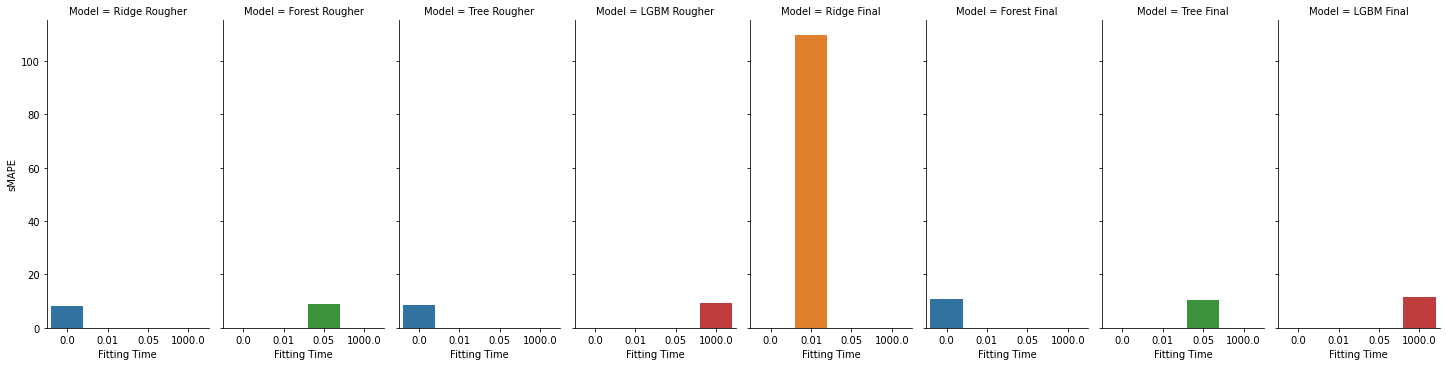

In [96]:
sns.catplot(data=results_table, x="Fitting Time", y="sMAPE", col="Model", kind="bar", aspect=0.5 )
plt.show()

In [100]:
print(ridge_params)
print(tree_params)
print(tree2_params)
print(forest2_params)

{'alpha': 0.8}
{'max_depth': 1}
{'max_depth': 1}
{'max_depth': 2, 'n_estimators': 10}


- The best two models for the flotation stage on the training sample are:
1. `Ridge(alpha=0.8)` with `sMAPE = 8.30`
2. `DecisionTreeRegressor(max_depth = 1)` with `sMAPE = 8.39`
- The best two models for the final stage on the training sample are:
1. `DecisionTreeRegressor(max_depth = 1)`, with `sMAPE = 10.54`
2. `RandomForestRegressor(max_depth = 2, n_estimators = 10)` with `sMAPE = 10.62`

## Testing

#### Adding the missing columns in `data_test `from `data_full`

In [61]:
columns_full = data_full.columns
columns_test = data_test.columns

missing_columns = [] + ['date']

for column in columns_full:
    if column not in columns_test:
        missing_columns.append(column)
        

data_test = data_test.merge(data_full[missing_columns], how = 'inner', on = 'date')

#### Creating `testing features & target` for the `flotation stage`

In [62]:
# determining the features
test_rougher_features = data_test[rougher_cols]
test_rougher_features = test_rougher_features.drop(drop_list, axis = 1)

# reducing dimension
test_rougher_features_reduced = reducer.fit_transform(test_rougher_features)

# determining the target
test_rougher_target = data_test['rougher.output.recovery']

#### Creating `testing features & target` for the `final stage`

In [63]:
# determining the features
test_final_features = data_test[final_cols]
test_final_features = test_final_features.drop(drop_list_final , axis = 1)

# reducing dimension
test_final_features_reduced = reducer.fit_transform(test_final_features)

# determining the target
test_final_target = data_test['final.output.recovery']

#### Testing the `random model (dummy)` on `flotation stage`

In [64]:
dummy_rougher = dummy.DummyRegressor(strategy = 'quantile', quantile = 0.5) # <-- random model

dummy_rougher.fit(rougher_features_reduced, rougher_target) # <--- fitting data_train 

prediction_dummy = dummy_rougher.predict(test_rougher_features_reduced) # <--- predicting data_test target

test_sMAPE_dummy = sMAPE(test_rougher_target, prediction_dummy) # <--- error

print('sMAPE of the random model on testing on flotation stage:', test_sMAPE_dummy)

sMAPE of the random model on testing on flotation stage: 9.156726289098653


#### Testing the `random model (dummy)` on the `final stage`

In [65]:
dummy_final = dummy.DummyRegressor(strategy = 'quantile', quantile = 0.5)

dummy_final.fit(final_features_reduced, final_target)

prediction_dummy2 = dummy_final.predict(test_final_features_reduced)

test_sMAPE_dummy2 = sMAPE(test_final_target, prediction_dummy2)

print('sMAPE of the random model on testing on the final stage:', test_sMAPE_dummy2)

sMAPE of the random model on testing on the final stage: 9.943107596851101


#### Testing the `best model #1` on the `flotation stage`

In [107]:
model_test_1 = linear_model.Ridge(random_state=42, alpha=0.8)# <-- best model for the rougher phase
model_test_1.fit(rougher_features_reduced, rougher_target) # <--- fitting train data

prediction_test_rougher_1 = model_test_1.predict(test_rougher_features_reduced) # <-- predicting test data target

test_sMAPE_rougher_1 = sMAPE(test_rougher_target, prediction_test_rougher_1) # <-- error

print('sMAPE on flotation stage:' , test_sMAPE_rougher_1)
print('Is our model adequate?', test_sMAPE_dummy > test_sMAPE_rougher_1)

sMAPE on flotation stage: 9.522754310764945
Is our model adequate? False


#### Testing the `best model #2` on the `flotation stage`

In [108]:
model_test_2 = DecisionTreeRegressor(random_state = 42, max_depth = 1)# <-- best model for the rougher phase
model_test_2.fit(rougher_features_reduced, rougher_target) # <--- fitting train data

prediction_test_rougher_2 = model_test_2.predict(test_rougher_features_reduced) # <-- predicting test data target

test_sMAPE_rougher_2 = sMAPE(test_rougher_target, prediction_test_rougher_2) # <-- error

print('sMAPE on flotation stage:' , test_sMAPE_rougher_2)
print('Is our model adequate?', test_sMAPE_dummy > test_sMAPE_rougher_2)

sMAPE on flotation stage: 9.03264304516249
Is our model adequate? True


#### Graph of the FLOTATION STAGE Testing Results

In [109]:
# our model

prediction_test_rougher_pd = pd.DataFrame(prediction_test_rougher_2)
compare_best_rougher = pd.concat([test_rougher_target, prediction_test_rougher_pd], axis=1)
compare_best_rougher.columns = ['Target', 'Prediction']

# dummy

prediction_dummy_pd = pd.DataFrame(prediction_dummy)
compare_dummy_rougher = pd.concat([test_rougher_target, prediction_dummy_pd], axis=1)
compare_dummy_rougher.columns = ['Target', 'Prediction']

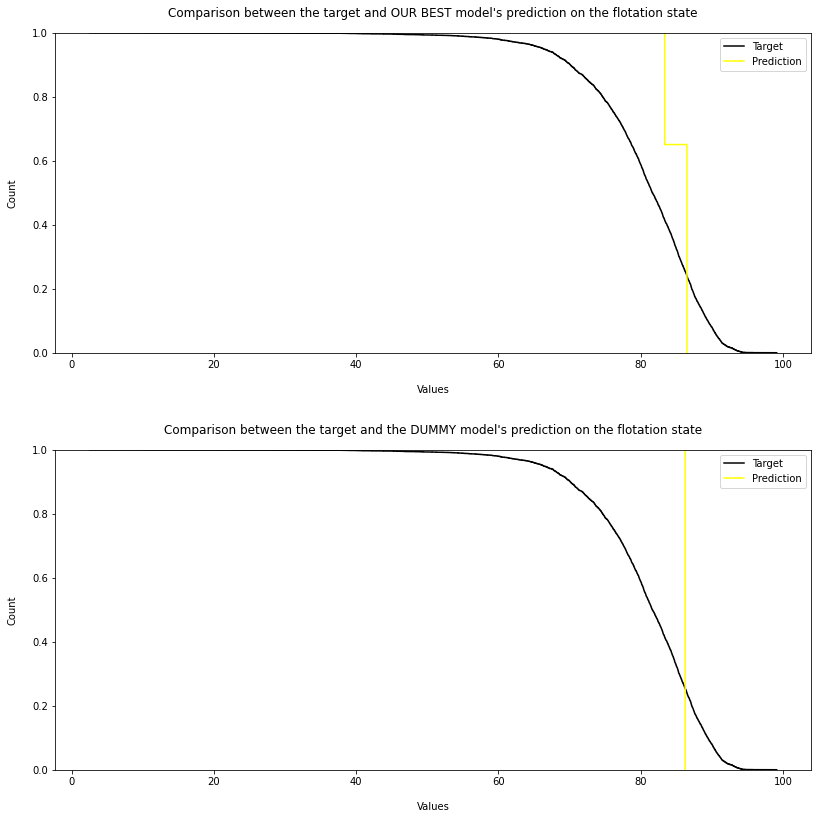

In [110]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

ax0.set_title("Comparison between the target and OUR BEST model's prediction on the flotation state", y = 1.03)

sns.ecdfplot(data=compare_best_rougher, x='Target', ax=ax0, color = 'black', complementary = True)
sns.ecdfplot(data=compare_best_rougher, x = 'Prediction', ax=ax0, color = 'yellow', complementary=True)

ax0.set_xlabel('Values', labelpad = 15)
ax0.set_ylabel('Count', labelpad = 15)

ax0.legend(loc='best', labels= ['Target','Prediction'])

ax1.set_title("Comparison between the target and the DUMMY model's prediction on the flotation state", y = 1.03)

sns.ecdfplot(data=compare_dummy_rougher, x='Target', ax=ax1, color = 'black', complementary=True)
sns.ecdfplot(data=compare_dummy_rougher, x = 'Prediction', ax=ax1, color = 'yellow', complementary=True)

ax1.set_xlabel('Values', labelpad = 15)
ax1.set_ylabel('Count', labelpad = 15)

ax1.legend(loc='best', labels= ['Target','Prediction'])

plt.tight_layout(pad = 3)

plt.show()

#### Testing the `best model #1` on the `final stage`

In [105]:
model_test_final_1 = DecisionTreeRegressor(random_state = 42, max_depth = 1) 

model_test_final_1.fit(final_features_reduced, final_target)

prediction_test_final_1 = model_test_final.predict(test_final_features_reduced)

test_sMAPE_final_1 = sMAPE(test_final_target, prediction_test_final_1)

print('sMAPE on the final stage:' , test_sMAPE_final_1)
print('Is this model adequate?', test_sMAPE_dummy2 > test_sMAPE_final_1)

sMAPE on the final stage: 9.727858186325905
Is this model adequate? True


#### Testing the `best model #2` on the `final stage`

In [106]:
model_test_final_2 =  ensemble.RandomForestRegressor(random_state = 42, n_estimators = 10, max_depth = 2)

model_test_final_2.fit(final_features_reduced, final_target)

prediction_test_final_2 = model_test_final_2.predict(test_final_features_reduced)

test_sMAPE_final_2 = sMAPE(test_final_target, prediction_test_final_2)

print('sMAPE on the final stage:' , test_sMAPE_final_2)
print('Is this model adequate?', test_sMAPE_dummy2 > test_sMAPE_final_2)

sMAPE on the final stage: 10.092164417549757
Is this model adequate? False


#### Graph of FINAL STAGE Testing Results

In [111]:
# our model

prediction_test_final_pd = pd.DataFrame(prediction_test_final_1)
compare_best_final = pd.concat([test_final_target, prediction_test_final_pd], axis=1)
compare_best_final.columns = ['Target', 'Prediction']

# dummy

prediction_dummy2_pd = pd.DataFrame(prediction_dummy2)
compare_dummy_final = pd.concat([test_final_target, prediction_dummy2_pd], axis=1)
compare_dummy_final.columns = ['Target', 'Prediction']

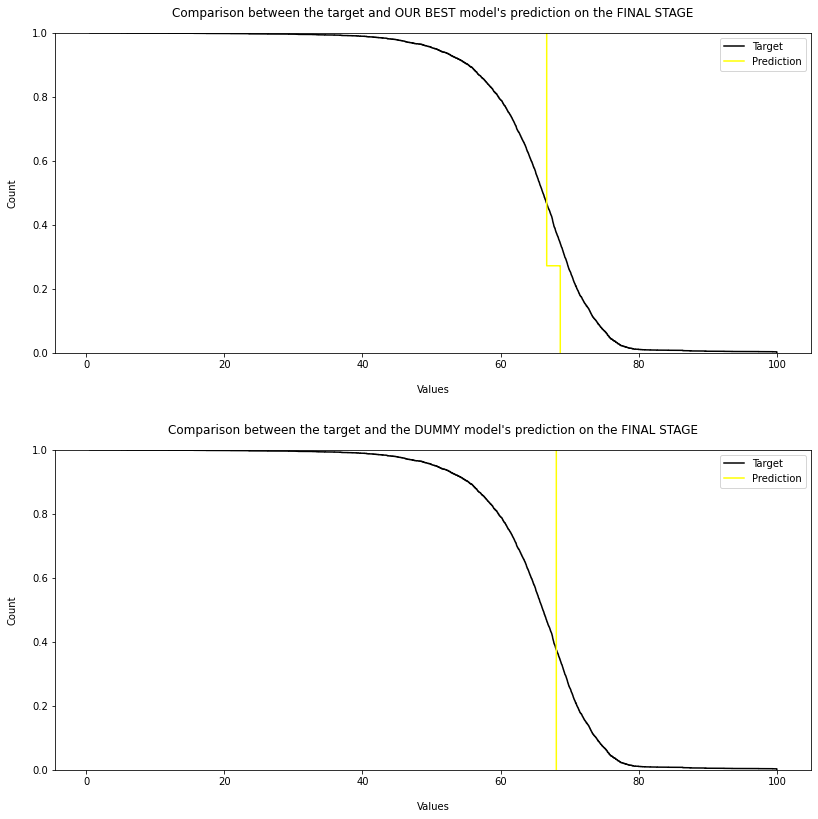

In [112]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

ax0.set_title("Comparison between the target and OUR BEST model's prediction on the FINAL STAGE", y = 1.03)

sns.ecdfplot(data=compare_best_final, x='Target', ax=ax0, color = 'black', complementary = True)
sns.ecdfplot(data=compare_best_final, x = 'Prediction', ax=ax0, color = 'yellow', complementary = True)

ax0.set_xlabel('Values', labelpad = 15)
ax0.set_ylabel('Count', labelpad = 15)

ax0.legend(loc='best', labels= ['Target','Prediction'])

ax1.set_title("Comparison between the target and the DUMMY model's prediction on the FINAL STAGE", y = 1.03)

sns.ecdfplot(data=compare_dummy_final, x='Target', ax=ax1, color = 'black', complementary = True)
sns.ecdfplot(data=compare_dummy_final, x = 'Prediction', ax=ax1, color = 'yellow', complementary = True)

ax1.set_xlabel('Values', labelpad = 15)
ax1.set_ylabel('Count', labelpad = 15)

ax1.legend(loc='best', labels= ['Target','Prediction'])

plt.tight_layout(pad = 3)

plt.show()

#### Concluding sMAPE

In [113]:
final_sMAPE  = sMAPE_final(test_sMAPE_rougher_2, test_sMAPE_final_1)
print(final_sMAPE)

9.554054401035053


####  Concluding sMAPE of the random model

In [114]:
dummy_final_sMAPE = sMAPE_final(test_sMAPE_dummy, test_sMAPE_dummy2)
print(dummy_final_sMAPE)

9.74651226991299


#### Is our model adequate?

In [115]:
final_sMAPE < dummy_final_sMAPE

True

## Conclusion

During the implementation of this project the following was carried out:


- The correct calculation of enrichment efficiency was verified.
- Missing columns were installed into `data_test`.
- Analysis of changes in the metal concentration between cleaning phases was done.
- A function to calculate sMAPE was created. 
- Feature dimensionality was reduced via UMAP for better predicting performance.
- Considering the nature of the data, several predicting models were created (Ridge Reg., Random Forest Reg., Decision Tree Reg. and LGBM) and the two best models for each, flotation and final stage, was selected:
    - Flotation stage: 
        - **1.** `Ridge(alpha=0.8)` with `sMAPE = 8.30` 
        - **2.** `DecisionTreeRegressor(max_depth=1)` with `sMAPE = 8.39`
    - Final stage: 
        - **1.** `DecisionTreeRegressor(max_depth=1)` with `sMAPE = 10.54` 
        - **2.** `RandomForestRegressor(max_depth=2, n_estimators=10)` with `sMAPE = 10.62`

- All of the seleceted best models were tested on the test sample and the DecisionTreeRegressor(max_depth=1) turned out to be the adequate for both stages, although with a sMAPE just minimally better than the random model's. 

Summary:

- The models that turned out to be the best are just slightly better than a random model; this might be due to the data nature itself:
    - **our best model's** sMAPE `9.03 vs. 9.16` of a **random model's** sMAPE on `flotation stage`
    - **our best model's** sMAPE `9.73 vs. 9.94` of a **random model's** sMAPE on the `final stage`
    - **our `concluding` sMAPE** `9.55 vs. 9.75` of a **random model's `concluding` sMAPE**
    
Although there turned out to be an adequate model for each phase in the testing, this cannot guarantee that they will be adequate once implemented in production, since, for instance, during the training phase, the best model for the flotation phase later gave worse results than the random model on the testing sample. It really depends on the data in question to be predicted, and given the nature of the data, it is unlikely that better results can be obtained.